# Time Series Final Project
---

## Project: Rossmann Store Sales Forecasting

**Description:**<br>
Rossmann operates over 3,000 drug stores in 7 European countries. The goal of this project is to predict daily sales for up to six weeks in advance for 1,115 Rossmann stores located across Germany. Accurate sales forecasts enable store managers to create effective staff schedules that increase productivity and motivation.

**Dataset:** <br>
- train.csv: Historical sales data for the stores.
- test.csv: Historical data without sales figures (to be predicted).
- store.csv: Supplemental information about the stores.


**Steps:** <br>
1. Data Analysis: Perform exploratory data analysis.
2. Simple Forecasting Models: 
    -  Implement and evaluate naive, average and Drift Forecasting models.
3. ETS Models: Apply Exponential Smoothing models and evaluate performance.
4. ARIMA Model: Apply ARIMA model and evaluate performance.
5. Prophet: Apply Prophet model and evaluate performance.
6. Machine Learning Model: Apply and evaluate a machine learning model for forecasting.
7. Model Selection and Forecasting: Choose the best model and forecast future sales on the test set.

**Evaluation Metric:** Root Mean Square Percentage Error (RMSPE)



## Import Libraries
Here I will import all the necessary libraries for the project.

In [228]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

from sklearn.metrics import mean_squared_error
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.stattools import kpss,adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from prophet import Prophet

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import tpot # AutoML library
from xgboost import XGBRegressor


# Just to hide all warnings.
import warnings
warnings.filterwarnings('ignore')
# just to get multuple output from the same cell.
# from IPython.core.interactiveshell import InteractiveShell
# InteractiveShell.ast_node_interactivity = "all"

## Function Definitions

In [326]:
# functiobn to get traning data for store 
def get_store_data(df,store_num):
    return df[df['Store'] == store_num].set_index('Date')['Sales']

def get_all_store_data(df,store_num):
    return df[df['Store'] == store_num]


def rmspe(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred)) / np.mean(y_true)


    
def create_lag_features(df,col_name,n_lags=10):
    for i in range(1,n_lags):
        df[f"{col_name}Lag_{i}"] = df[f'{col_name}'].shift(i)
    return df

# def rmspe(y_true , y_pred):
#     y_true = np.array(y_true)
#     y_pred = np.array(y_pred)   
#     return np.sqrt(np.mean(((y_true - y_pred) / y_true ) ** 2))

def naive_forecast(train_data, validation_data):
    last_sales = train_data.groupby('Store')['Sales'].last().reset_index()
    predictions = validation_data[['Store', 'Date']].copy()
    predictions = predictions.merge(last_sales, on='Store', how='left')
    predictions.rename(columns={'Sales': 'PredictedSales'}, inplace=True)
    return predictions


def average_method(train_data, validation_data):
    average_sales = train_data.groupby('Store')['Sales'].mean()
    predictions = validation_data[['Store', 'Date']].copy()
    # Add the average sales to each Store
    predictions = predictions.merge(average_sales, on='Store', how='left')
    predictions.rename(columns={'Sales': 'PredictedSales'}, inplace=True)
    return predictions

def drift_method(train_data, validation_data):
    drift_predictions = validation_data[['Store' , 'Date']].copy()
    drift_predictions['PredictedSales'] = np.nan
    
    for store in train_data['Store'].unique():
        train_store_data = train_data[train_data['Store'] == store].set_index('Date')['Sales']
        validation_store_data = validation_data[validation_data['Store'] == store]
        
        y_t = train_store_data.iloc[-1]
        m = (y_t - train_store_data.iloc[0]) / (len(train_store_data) - 1)
        h = np.arange(1, len(validation_store_data) + 1)
        drift_prediction = y_t + m * h
        
        drift_predictions.loc[drift_predictions['Store'] == store, 'PredictedSales'] = drift_prediction
    
    return drift_predictions




# Now we will make a function that extract the sorted Sales data for provided store number and apllay ExponentialSmoothing.
def Exponential_Smoothing(train_data, validation_data, store_num):
    train_store_data = train_data[train_data['Store'] == store_num].set_index('Date')['Sales']
    validation_store_data = validation_data[validation_data['Store'] == store_num]
    
    model = ExponentialSmoothing(train_store_data, trend='add', seasonal='add', seasonal_periods=7)
    model_fit = model.fit()
    
    forecast = model_fit.forecast(len(validation_store_data))
    
    validation_store_data['PredictedSales'] = forecast.values
    
    return validation_store_data
    
####################################### ARIMA ########################################
def get_store_data_ARIMA(df,store_num):
    store_df = df[df['Store'] == store_num]
    store_df.set_index('Date',inplace=True)
    return store_df

def ARIMA_Model(train_data, Order  , Seasonal_order ):
    model = ARIMA(train_data, order=Order , seasonal_order=Seasonal_order)
    model_fit = model.fit()
    return model_fit

def ARIMA_Predict(model_fit,start_index,end_index ):
    Prediction = model_fit.predict(start=start_index, end=end_index)
    return Prediction

def kpss_test(data,threshold=0.05,regression="c"):
    result = kpss(data,regression="c")
    print('KPSS Statistic:', result[0])
    print('p-value:', result[1])
    print('Lags Used:', result[2])
    print('Critical Values:')
    for key, value in result[3].items():
        print('\t{}: {}'.format(key, value))
    if result[1]<=threshold:
        print("The data is not stationary")
    else:
        print("The data is stationary")



def adf_test(data,threshold=0.05):
    # Perform ADF test
    result = adfuller(data,autolag="AIC")

    # Print test results
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t{}: {}'.format(key, value))

    if result[1] <= threshold:
        print("Conclusion:====>")
        print("Reject the null hypothesis")
        print("Data is stationary")
    else:
        print("Conclusion:====>")
        print("Fail to reject the null hypothesis")
        print("Data is non-stationary")


def autocorrelatin_graphs(value,n_lags,title_text):
    fig, axes = plt.subplots(3,1,dpi=80)
    fig.set_figheight(12)
    fig.set_figwidth(16)
    value_plot = axes[0].plot(value)
    plt.title(f'{title_text}')
    acf_plot = plot_acf(value, lags=n_lags, title=f'Autocorrelation in {title_text}',ax=axes[1])
    plt.xlabel('Lags')
    pacf_plot = plot_pacf(value, lags=n_lags, title=f'Partial Autocorrelation in {title_text}',ax=axes[2])
    plt.xlabel('Lags')
    plt.tight_layout()
    plt.show()

    

def Applay_ARIMA_To_Store(store_num , train_data , validation_data , Order , Seasonal_order , Plot = False):
    store_data = get_store_data_ARIMA(train_data,store_num)
    store_data_validation = get_store_data_ARIMA(validation_data,store_num)
    model_fit = ARIMA_Model(store_data[["Sales"]], Order , Seasonal_order)
    start_index = store_data_validation.index[0]
    end_index = store_data_validation.index[-1]
    Prediction = ARIMA_Predict(model_fit,start_index,end_index)
    if Plot:
        Plot_train_validation_AREMA(store_data_validation, Prediction, store_num)
    return rmspe(store_data_validation['Sales'] + 1 , Prediction)



def Plot_train_validation_AREMA(test_AREMA_Data, predected_AREMA_Data, store_num ):
    plt.figure(figsize=(21,8))
    plt.plot(test_AREMA_Data.index, test_AREMA_Data[test_AREMA_Data["Store"] == store_num]["Sales"], label='Test Data')
    plt.plot(predected_AREMA_Data.index, predected_AREMA_Data.values, label='AREMA')
    plt.title(f'Store {store_num} Sales ARIMA prediction')
    plt.xlabel('Date')
    plt.ylabel('Sales')
    plt.legend()
    plt.show()



############################################### Prophet #############################################

def prophet_forecast(train_data, validation_data, store_number):
    """
    Fit a Prophet model to the train_data for a specific store and make predictions.

    Parameters:
    - train_data: DataFrame containing the time series data with columns 'Date', 'Store', and 'Sales'.
    - validation_data: DataFrame containing the validation time series data with columns 'Date', 'Store', and 'Sales'.
    - store_number: The store number for which the forecast is to be made.

    Returns:
    - predictions: Forecasted values for the validation period.
    """

    # Filter data for the specific store.
    store_train_data = train_data[train_data['Store'] == store_number][['Date', 'Sales']]
    store_validation_data = validation_data[validation_data['Store'] == store_number][['Date', 'Sales']]

    # Rename columns to ds (date) and y (value) as required by Prophet.
    store_train_data = store_train_data.rename(columns={'Date': 'ds', 'Sales': 'y'})
    store_validation_data = store_validation_data.rename(columns={'Date': 'ds', 'Sales': 'y'})

    # Fit model
    model = Prophet(weekly_seasonality=True,  seasonality_mode='multiplicative')
    model.fit(store_train_data)

    # Make predictions
    future = model.make_future_dataframe(periods=len(store_validation_data), freq='D')
    forecast = model.predict(future)

    # Plotting
    fig, ax = plt.subplots(figsize=(17, 6))
    model.plot(forecast, ax=ax)
    ax.plot(store_validation_data['ds'], store_validation_data['y'], 'r', label='Validation Data')
    ax.set_xlabel('Date')
    ax.set_ylabel('Sales')
    ax.set_title(f'Sales Forecast for Store {store_number} using Prophet')
    ax.legend()
    plt.show()

    # Extract predictions for the validation period & calculate RMSPE
    predictions = forecast.set_index('ds').loc[store_validation_data['ds']]['yhat'].values
    rmspe_score = rmspe(store_validation_data['y'] + 1, predictions + 1)
    return predictions , rmspe_score


######################################### Decision Tree #############################################

# Random Forest Regressor function that takes the store number and the data and returns the RMSPE score and plots.
def random_forest_regressor(store_num, train_data, validation_data):
    store_train = get_all_store_data(train_data, store_num)
    store_validation = get_all_store_data(validation_data, store_num)

    X_train = store_train.drop(columns=['Sales', 'Date' , 'Store'], axis=1)
    y_train = store_train['Sales']

    X_val = store_validation.drop(columns=['Sales', 'Date' , 'Store'], axis=1)
    y_val = store_validation['Sales']

    rf = RandomForestRegressor(n_estimators=100, random_state=42)
    rf.fit(X_train, y_train)

    y_pred = rf.predict(X_val)

    rmspe_score = rmspe(y_val, y_pred)

    store_validation["Model_pred"] = y_pred

    Plot_train_validation(store_validation, store_validation, store_num, pred_col_name='Model_pred', Label1="True Valdation",
                          Label2="Prediction")

    return rmspe_score





############################################### Plots ###############################################


def draw_seasonal_box_plot(df, col_name):
    # Draw Plot
    #plt.figure(figsize=(10, 10))  # Adjust the figsize as needed
    fig, axes = plt.subplots(1, 4,figsize=(15, 10))
    sns.boxplot(x='Year', y=col_name, data=df, ax=axes[0])
    sns.boxplot(x='Month', y=col_name, data=df, ax=axes[1])
    sns.boxplot(x='DayOfWeek', y=col_name, data=df, ax=axes[2])
    sns.boxplot(x='StoreType', y=col_name, data=df, ax=axes[3])
    # Set Title
    axes[0].set_title('Year-wise Box Plot\n(The Trend)', fontsize=10)
    axes[1].set_title('Month-wise Box Plot\n(The Seasonality)', fontsize=10)
    axes[2].set_title('Day-wise Box Plot\n(The Seasonality)', fontsize=10)
    axes[3].set_title('StoreType-wise Box Plot\n(The Seasonality)', fontsize=10)
    
    plt.tight_layout()
    plt.show()
    

def Plot_train_validation(train_data, validation_data, store_num , pred_col_name = 'Sales', True_valdation = None  , Plot_true = False , Label1 = 'Train', Label2 = 'Validation', Label3 = 'True Validation' ):
    plt.figure(figsize=(21,8))
    plt.plot(train_data[train_data["Store"] == store_num]["Date"], train_data[train_data["Store"] == store_num]["Sales"], label=Label1)
    plt.plot(validation_data[validation_data["Store"] == store_num]["Date"], validation_data[validation_data["Store"] == store_num][pred_col_name], label=Label2)
    if Plot_true:
        plt.plot(True_valdation[True_valdation["Store"] == store_num]["Date"], True_valdation[True_valdation["Store"] == store_num]["Sales"], label=Label3)
    plt.title(f'Store {store_num} Sales')
    plt.xlabel('Date')
    plt.ylabel('Sales')
    plt.legend()
    plt.show()



## Step 1: Data Analysis

### Load Data

In [74]:
train = pd.read_csv(r'Data\train.csv' , parse_dates = True , low_memory = False)
test = pd.read_csv(r'Data\test.csv', parse_dates = True , low_memory = False)
store = pd.read_csv(r'Data\store.csv')

### Data Description

In [4]:
store.head()
train.head()
#test.head() # jUST LIKE THE TRAIN DATA BUT WITHOUT THE SALES COLUMN.

Store StoreType Assortment  CompetitionDistance  CompetitionOpenSinceMonth  \
0      1         c          a               1270.0                        9.0   
1      2         a          a                570.0                       11.0   
2      3         a          a              14130.0                       12.0   
3      4         c          c                620.0                        9.0   
4      5         a          a              29910.0                        4.0   

   CompetitionOpenSinceYear  Promo2  Promo2SinceWeek  Promo2SinceYear  \
0                    2008.0       0              NaN              NaN   
1                    2007.0       1             13.0           2010.0   
2                    2006.0       1             14.0           2011.0   
3                    2009.0       0              NaN              NaN   
4                    2015.0       0              NaN              NaN   

     PromoInterval  
0              NaN  
1  Jan,Apr,Jul,Oct  
2  Jan,Apr,Jul,Oct  
3              NaN  
4              NaN

Store  DayOfWeek        Date  Sales  Customers  Open  Promo StateHoliday  \
0      1          5  2015-07-31   5263        555     1      1            0   
1      2          5  2015-07-31   6064        625     1      1            0   
2      3          5  2015-07-31   8314        821     1      1            0   
3      4          5  2015-07-31  13995       1498     1      1            0   
4      5          5  2015-07-31   4822        559     1      1            0   

   SchoolHoliday  
0              1  
1              1  
2              1  
3              1  
4              1

Data Fields:
- Id: Represents a (Store, Date) tuple within the test set.
- Store: Unique ID for each store.
- Sales: Turnover for any given day (target variable).
- Customers: Number of customers on a given day.
- Open: Indicator for whether the store was open (0 = closed, 1 = open).
- StateHoliday: Indicates a state holiday (a = public holiday, b = Easter holiday, c = Christmas, 0 = None).
- SchoolHoliday: Indicates if the (Store, Date) was affected by the closure of public schools.
- StoreType: Differentiates between 4 different store models (a, b, c, d).
- Assortment: Describes an assortment level (a = basic, b = extra, c = extended).
- CompetitionDistance: Distance to the nearest competitor store in meters.
- CompetitionOpenSince[Month/Year]: Approximate year and month the nearest competitor was opened.
- Promo: Indicates if a store is running a promo on that day.
- Promo2: Continuing and consecutive promotion for some stores (0 = not participating, 1 = participating).
- Promo2Since[Year/Week]: Year and calendar week when the store started participating in Promo2.
- PromoInterval: Consecutive intervals Promo2 is started anew (e.g., "Feb,May,Aug,Nov").

In [5]:
train.shape
train.info()
print('---------------Store.csv------------------')
store.shape 
store.info()


(1017209, 9)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 9 columns):
 #   Column         Non-Null Count    Dtype 
---  ------         --------------    ----- 
 0   Store          1017209 non-null  int64 
 1   DayOfWeek      1017209 non-null  int64 
 2   Date           1017209 non-null  object
 3   Sales          1017209 non-null  int64 
 4   Customers      1017209 non-null  int64 
 5   Open           1017209 non-null  int64 
 6   Promo          1017209 non-null  int64 
 7   StateHoliday   1017209 non-null  object
 8   SchoolHoliday  1017209 non-null  int64 
dtypes: int64(7), object(2)
memory usage: 69.8+ MB
---------------Store.csv------------------


(1115, 10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1115 entries, 0 to 1114
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Store                      1115 non-null   int64  
 1   StoreType                  1115 non-null   object 
 2   Assortment                 1115 non-null   object 
 3   CompetitionDistance        1112 non-null   float64
 4   CompetitionOpenSinceMonth  761 non-null    float64
 5   CompetitionOpenSinceYear   761 non-null    float64
 6   Promo2                     1115 non-null   int64  
 7   Promo2SinceWeek            571 non-null    float64
 8   Promo2SinceYear            571 non-null    float64
 9   PromoInterval              571 non-null    object 
dtypes: float64(5), int64(2), object(3)
memory usage: 87.2+ KB


There are some Null values in `CompetitionDistance`, `CompetitionOpenSinceMonth`, `CompetitionOpenSinceYear`, `Promo2SinceWeek`, and `Promo2SinceYear` columns. 

In [53]:
train.describe().apply(lambda s: s.apply('{0:.5f}'.format)) # To not use scientific notation.

Store      DayOfWeek           Date          Sales  \
count  1017209.00000  1017209.00000  1017209.00000  1017209.00000   
mean       558.42973        3.99834            .5f     5773.81897   
min          1.00000        1.00000            .5f        0.00000   
25%        280.00000        2.00000            .5f     3727.00000   
50%        558.00000        4.00000            .5f     5744.00000   
75%        838.00000        6.00000            .5f     7856.00000   
max       1115.00000        7.00000            .5f    41551.00000   
std        321.90865        1.99739            nan     3849.92618   

           Customers           Open          Promo  SchoolHoliday  \
count  1017209.00000  1017209.00000  1017209.00000  1017209.00000   
mean       633.14595        0.83011        0.38151        0.17865   
min          0.00000        0.00000        0.00000        0.00000   
25%        405.00000        1.00000        0.00000        0.00000   
50%        609.00000        1.00000        0.00000        0.00000   
75%        837.00000        1.00000        1.00000        0.00000   
max       7388.00000        1.00000        1.00000        1.00000   
std        464.41173        0.37554        0.48576        0.38306   

      CompetitionDistance CompetitionOpenSinceMonth CompetitionOpenSinceYear  \
count       1014567.00000              693861.00000             693861.00000   
mean           5430.08565                   7.22287               2008.69023   
min              20.00000                   1.00000               1900.00000   
25%             710.00000                   4.00000               2006.00000   
50%            2330.00000                   8.00000               2010.00000   
75%            6890.00000                  10.00000               2013.00000   
max           75860.00000                  12.00000               2015.00000   
std            7715.32370                   3.21183                  5.99264   

              Promo2 Promo2SinceWeek Promo2SinceYear  
count  1017209.00000    509178.00000    509178.00000  
mean         0.50056        23.26909      2011.75277  
min          0.00000         1.00000      2009.00000  
25%          0.00000        13.00000      2011.00000  
50%          1.00000        22.00000      2012.00000  
75%          1.00000        37.00000      2013.00000  
max          1.00000        50.00000      2015.00000  
std          0.50000        14.09597         1.66287

### Merge Data

In [75]:
train = train.merge(store, on='Store', how='left')
test = test.merge(store, on='Store', how='left')

In [35]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 18 columns):
 #   Column                     Non-Null Count    Dtype  
---  ------                     --------------    -----  
 0   Store                      1017209 non-null  int64  
 1   DayOfWeek                  1017209 non-null  int64  
 2   Date                       1017209 non-null  object 
 3   Sales                      1017209 non-null  int64  
 4   Customers                  1017209 non-null  int64  
 5   Open                       1017209 non-null  int64  
 6   Promo                      1017209 non-null  int64  
 7   StateHoliday               1017209 non-null  object 
 8   SchoolHoliday              1017209 non-null  int64  
 9   StoreType                  1017209 non-null  object 
 10  Assortment                 1017209 non-null  object 
 11  CompetitionDistance        1014567 non-null  float64
 12  CompetitionOpenSinceMonth  693861 non-null   float64
 13  CompetitionO

### Convert Date columns to datetime

In [76]:
train['Date'] = pd.to_datetime(train['Date'])
test['Date'] = pd.to_datetime(test['Date'])

### Handle Missing Values

Only 3 missing values in `CompetitionDistance` column. I will fill them with `median`.

In [90]:
store[store['CompetitionDistance'].isnull()]

Store StoreType Assortment  CompetitionDistance  \
290    291         d          a                  NaN   
621    622         a          c                  NaN   
878    879         d          a                  NaN   

     CompetitionOpenSinceMonth  CompetitionOpenSinceYear  Promo2  \
290                        NaN                       NaN       0   
621                        NaN                       NaN       0   
878                        NaN                       NaN       1   

     Promo2SinceWeek  Promo2SinceYear    PromoInterval  
290              NaN              NaN              NaN  
621              NaN              NaN              NaN  
878              5.0           2013.0  Feb,May,Aug,Nov

In [77]:
train['CompetitionDistance'] = train['CompetitionDistance'].fillna(train['CompetitionDistance'].median())
test['CompetitionDistance'] = test['CompetitionDistance'].fillna(test['CompetitionDistance'].median())


Deling with missing values in other columns will be delayed for now.

### Creating new features from Date

In [78]:
train['Year'] = train['Date'].dt.year
train['Month'] = train['Date'].dt.month
train['Day'] = train['Date'].dt.day
train['DayOfWeek'] = train['Date'].dt.dayofweek

test['Year'] = test['Date'].dt.year
test['Month'] = test['Date'].dt.month
test['Day'] = test['Date'].dt.day
test['DayOfWeek'] = test['Date'].dt.dayofweek

### Exploratory Data Analysis

### Sales distribution

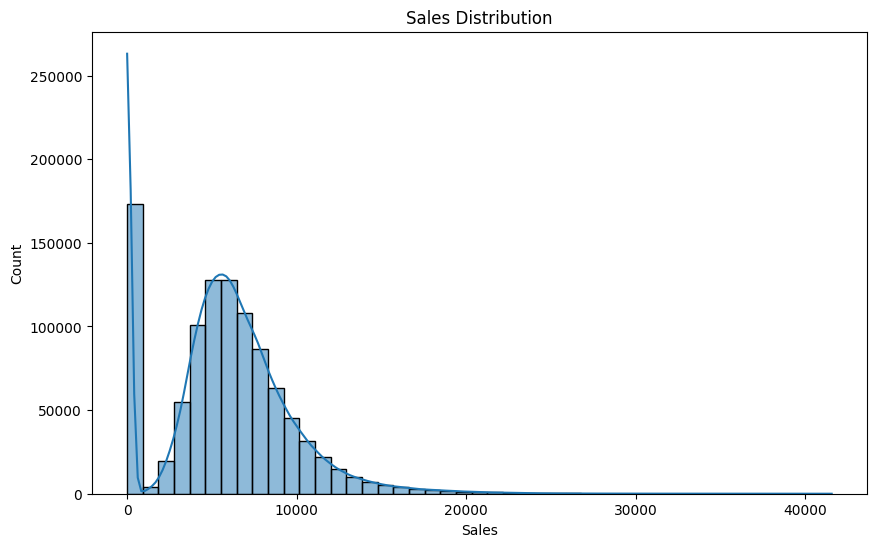

In [17]:
plt.figure(figsize=(10,6))
sns.histplot(train['Sales'], bins=45, kde=True)
plt.title('Sales Distribution')
plt.show()

This peek at the zero is normal, as the stores seles must be zero when the stores are closed.

### Sales over time

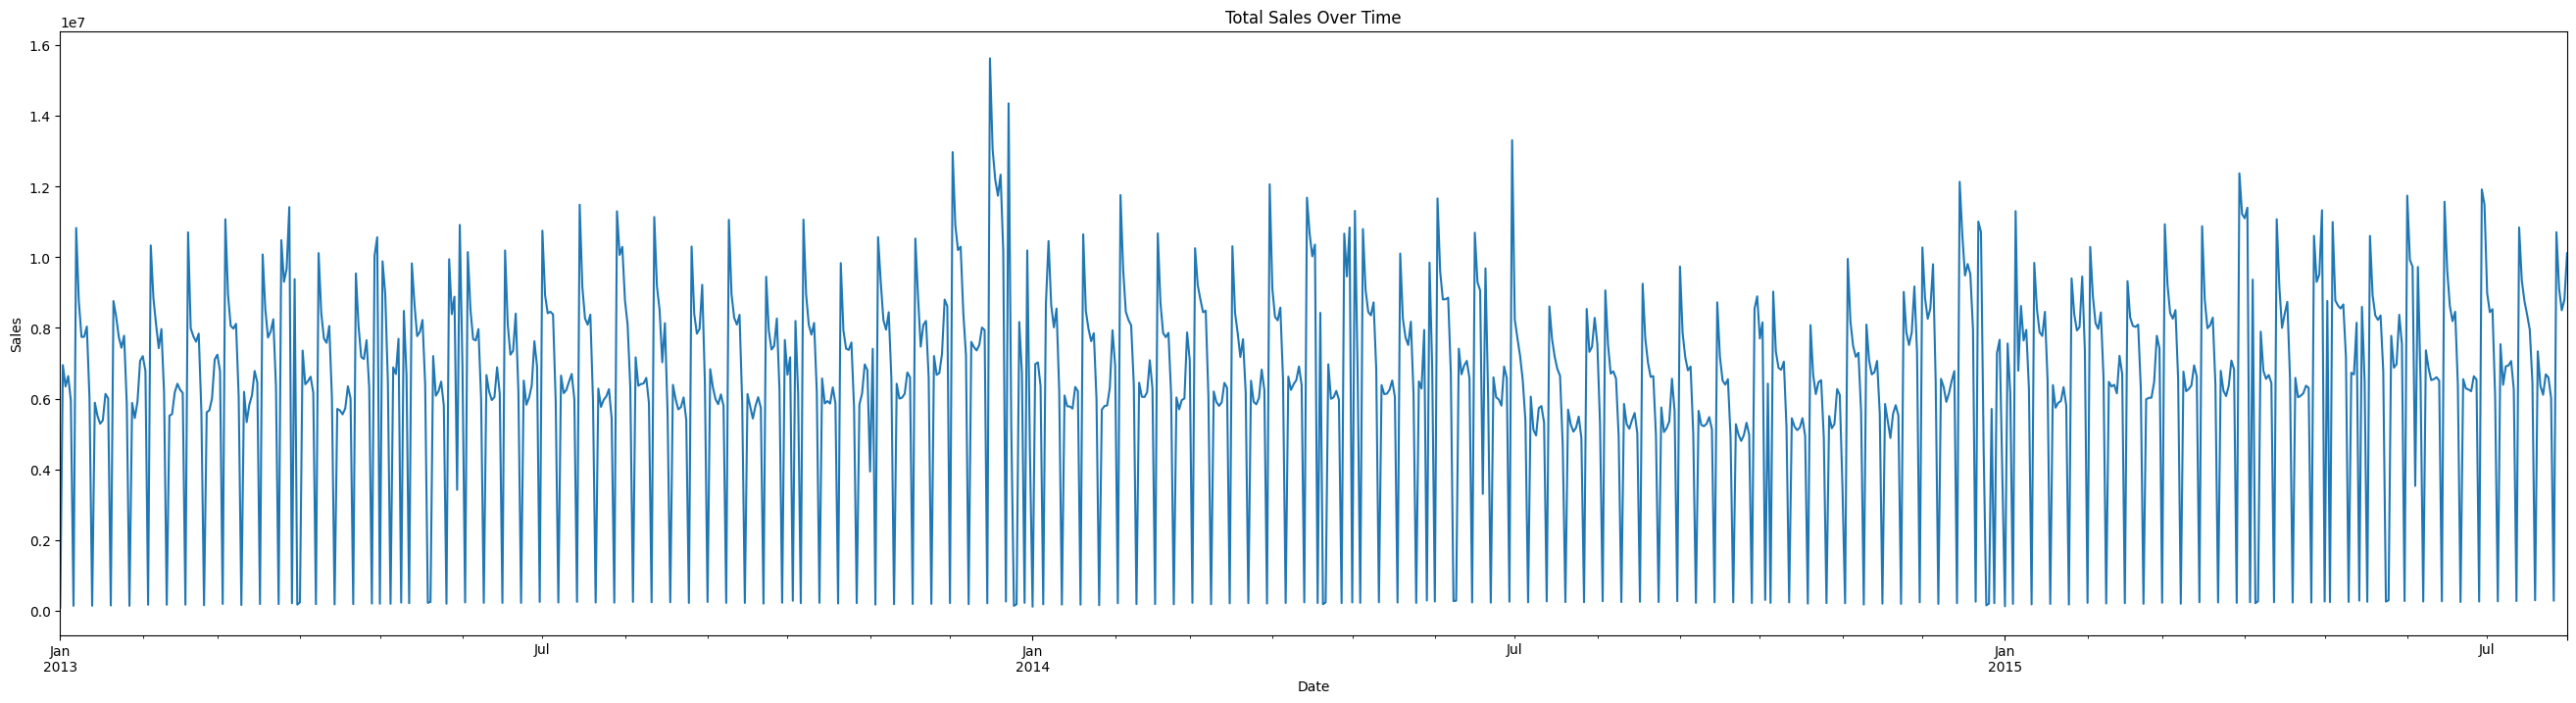

In [16]:
plt.figure(figsize=(33,8))
train.groupby('Date')['Sales'].sum().plot()
plt.title('Total Sales Over Time')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.show()

Data shows very stady trend over time. The sales are high in the beginning (of the week maybe) and gets lower by time to reach zero when the store is closed. <br> 
Let's isolate only one random store and see the sales trend in a bart of the time. <br>

In [14]:
A_store = train[train['Store'] == 42]

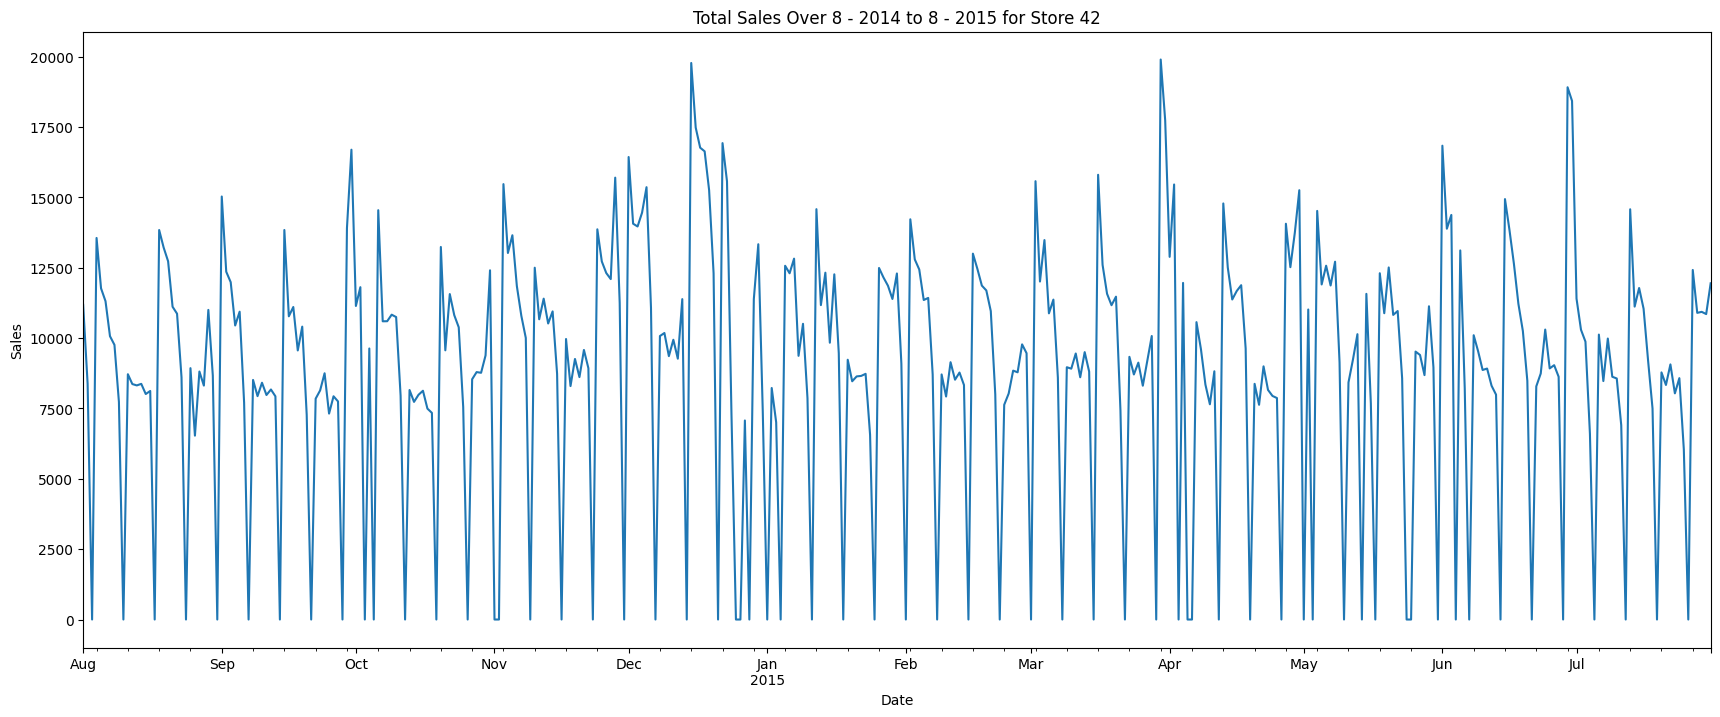

In [15]:
# let's only plot one year of data.
A_store = A_store[A_store['Date'] > '2014-07-31']
plt.figure(figsize=(21,8))
A_store.groupby('Date')['Sales'].sum().plot()
plt.title('Total Sales Over 8 - 2014 to 8 - 2015 for Store 42')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.show()

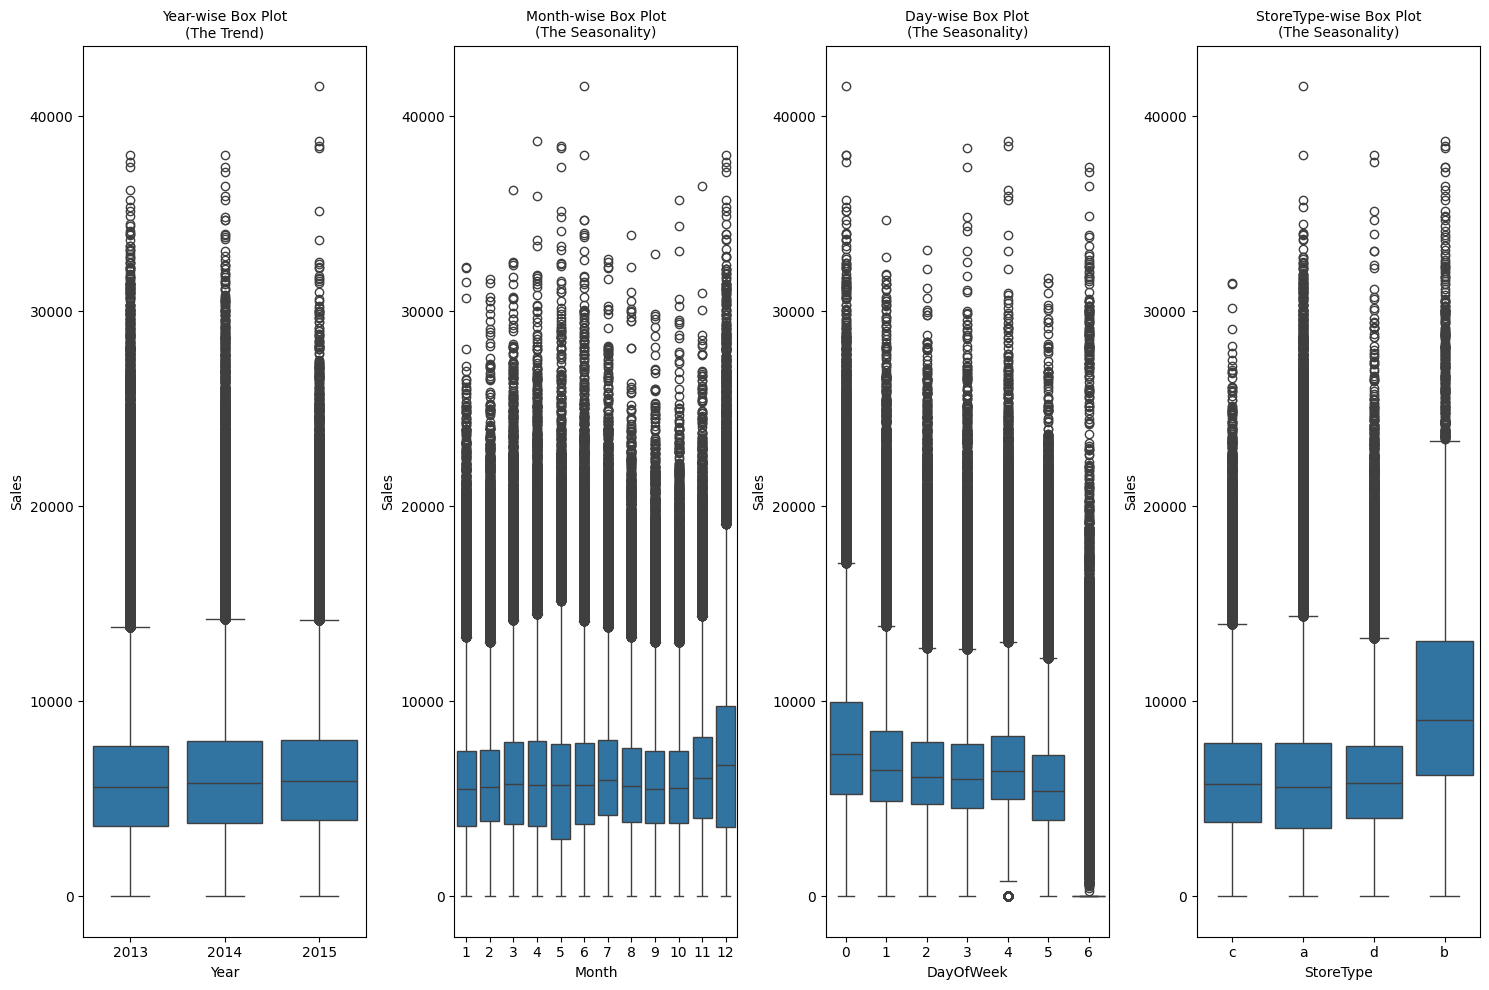

In [119]:
draw_seasonal_box_plot(train, 'Sales')

The Avrage is almost constant over the years. <br>
most Sales are zero in the 6th day of the week. <br>
Store type b has the highest avrage sales, maybe we will use different models for different store types. <br>

In [317]:
train['Date'].min(), train['Date'].max()

(Timestamp('2013-01-01 00:00:00'), Timestamp('2015-07-31 00:00:00'))

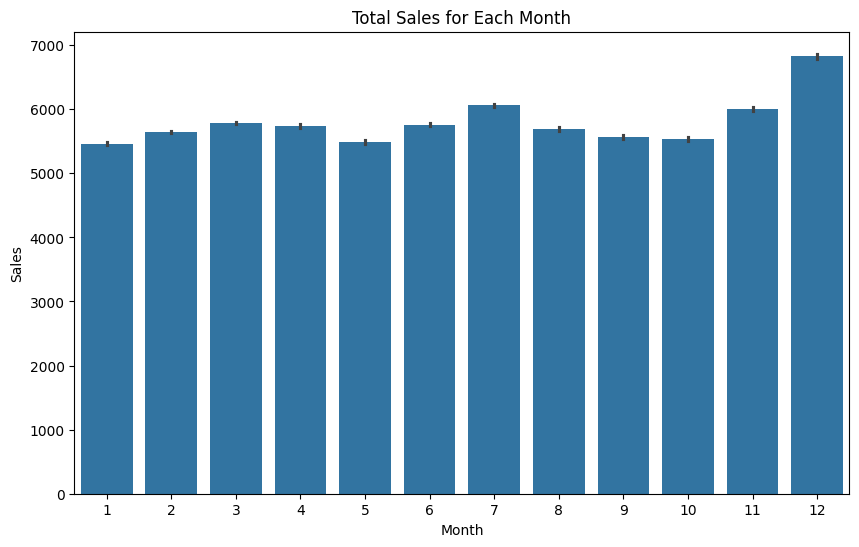

In [13]:
# Total sales for each month
plt.figure(figsize=(10,6))
sns.barplot(x='Month', y='Sales', data=train)
plt.title('Total Sales for Each Month')
plt.show()


Looks like `December` is the month with the highest sales dispite it accures only towice in the data and other months (1 - 7 ) accure 3 times, maybe black Frayday. <br>

### Visualizing the Impact of Promotions on Sales

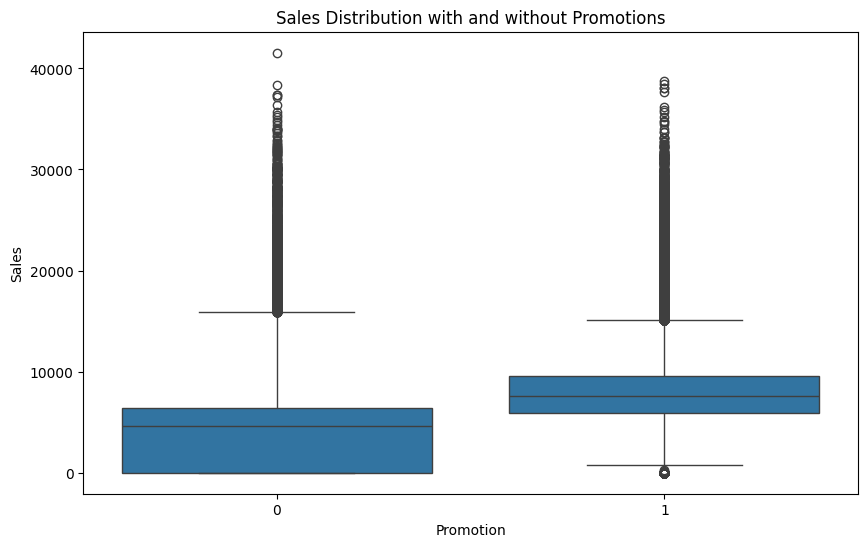

In [440]:
plt.figure(figsize=(10,6))
sns.boxplot(data=train, x='Promo', y='Sales')
plt.title('Sales Distribution with and without Promotions')
plt.xlabel('Promotion')
plt.ylabel('Sales')
plt.show()


Using `Promo` slihtly increases the avrage sales. <br>

### Visualizing the Effect of State Holidays on Sales

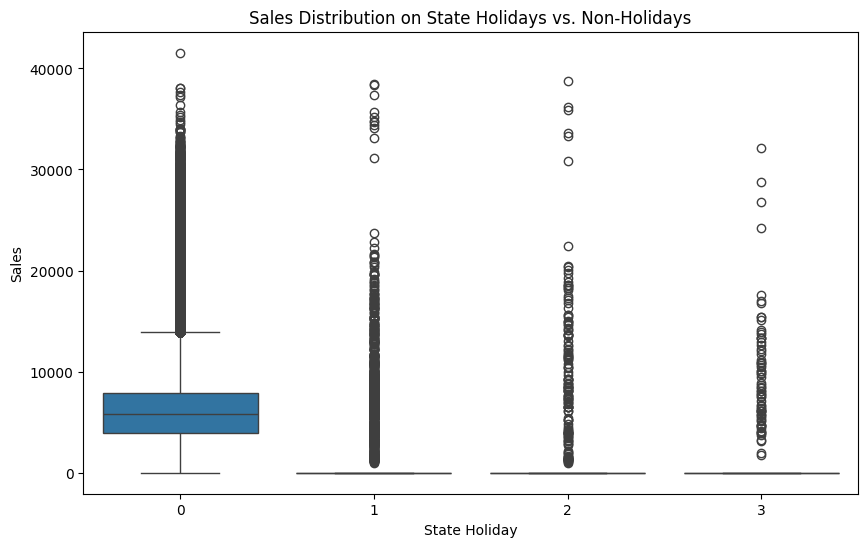

In [439]:
plt.figure(figsize=(10,6))
sns.boxplot(data=train, x='StateHoliday', y='Sales')
plt.title('Sales Distribution on State Holidays vs. Non-Holidays')
plt.xlabel('State Holiday')
plt.ylabel('Sales')
plt.show()


Sales are lower on state holidays, maybe because the stores are closed. <br>

### Visualizing the Effect of School Holidays on Sales

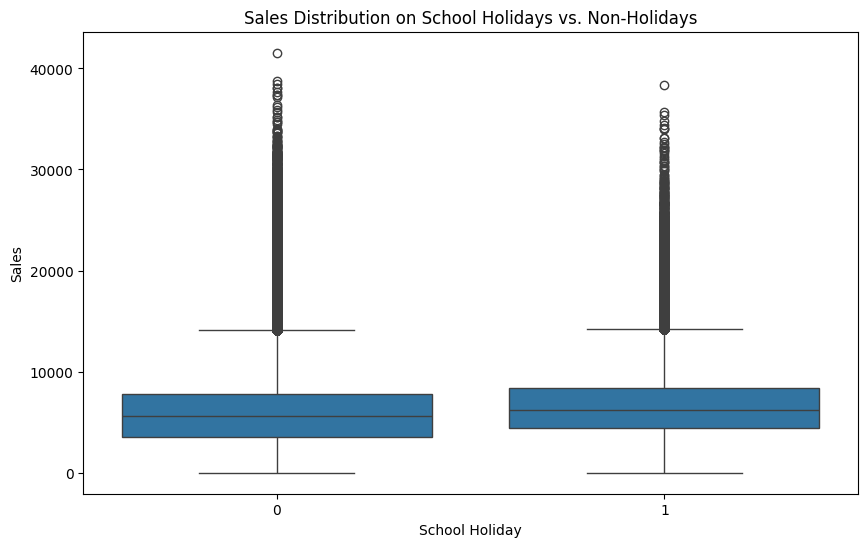

In [438]:
# Sales distribution on school holidays vs. non-holidays
plt.figure(figsize=(10,6))
sns.boxplot(data=train, x='SchoolHoliday', y='Sales')
plt.title('Sales Distribution on School Holidays vs. Non-Holidays')
plt.xlabel('School Holiday')
plt.ylabel('Sales')
plt.show()


School holidays have no effect on sales. <br>

## Step 2: Simple Forecasting Models

Forecasting on a day that the store is closed doesn't make since. <br>

In [79]:
train_Open = train[train['Open'] == 1]
train_Open = train_Open.sort_values(['Store', 'Date'])

### Train Test Split

I toke the last 24 weeks as the test set. <br>


In [80]:
validation_start_date = train_Open['Date'].max() - pd.Timedelta(weeks=24)
train_data = train_Open[train_Open['Date'] < validation_start_date]
validation_data = train_Open[train_Open['Date'] >= validation_start_date]


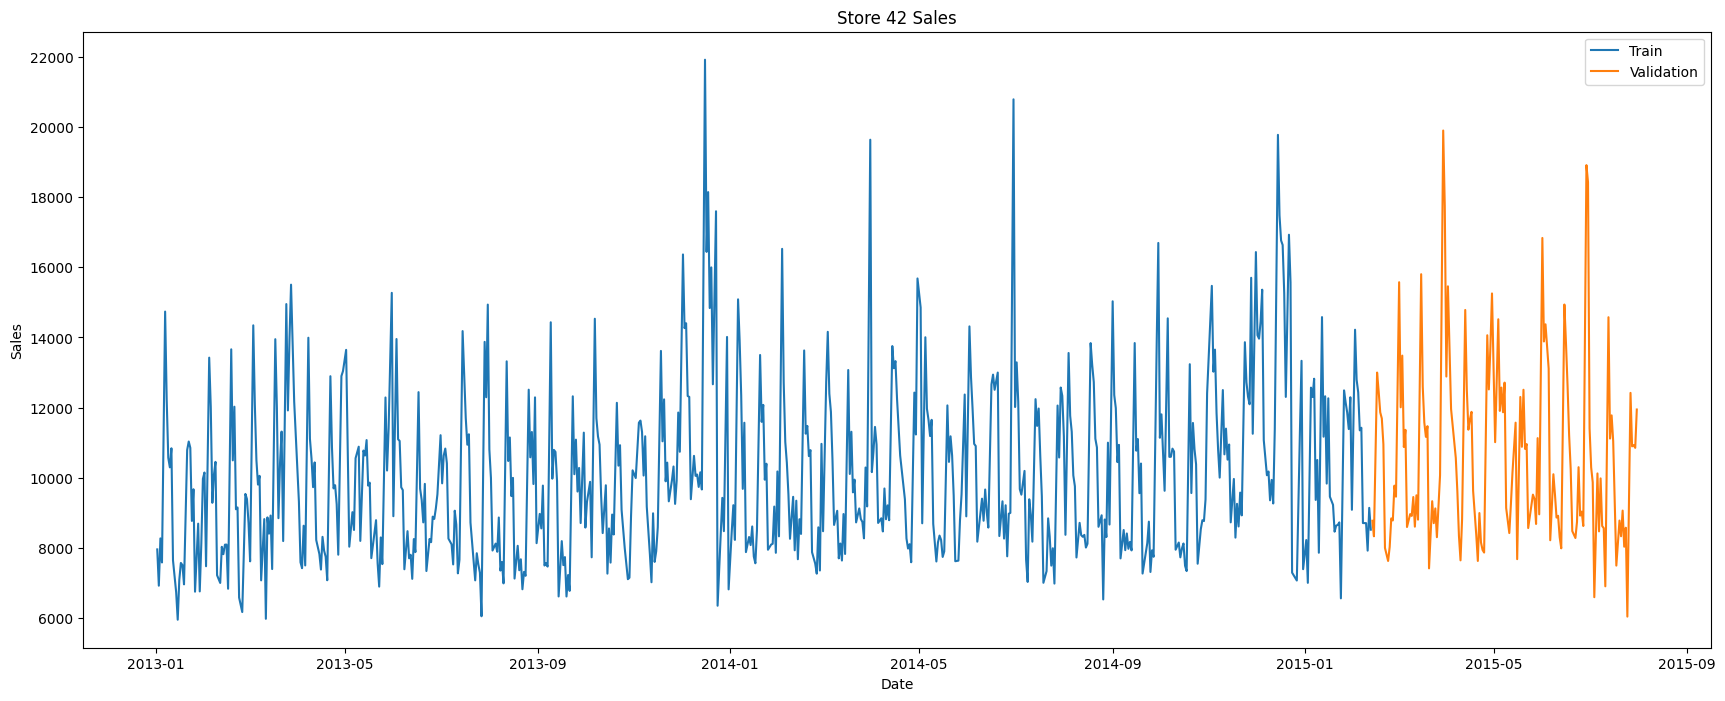

In [10]:
Plot_train_validation(train_data, validation_data, 42)

### Naive Forecast

In [81]:
naive_predictions = naive_forecast(train_data, validation_data)
rmspe(validation_data['Sales'] + 1 , naive_predictions['PredictedSales'])

0.376344788042073

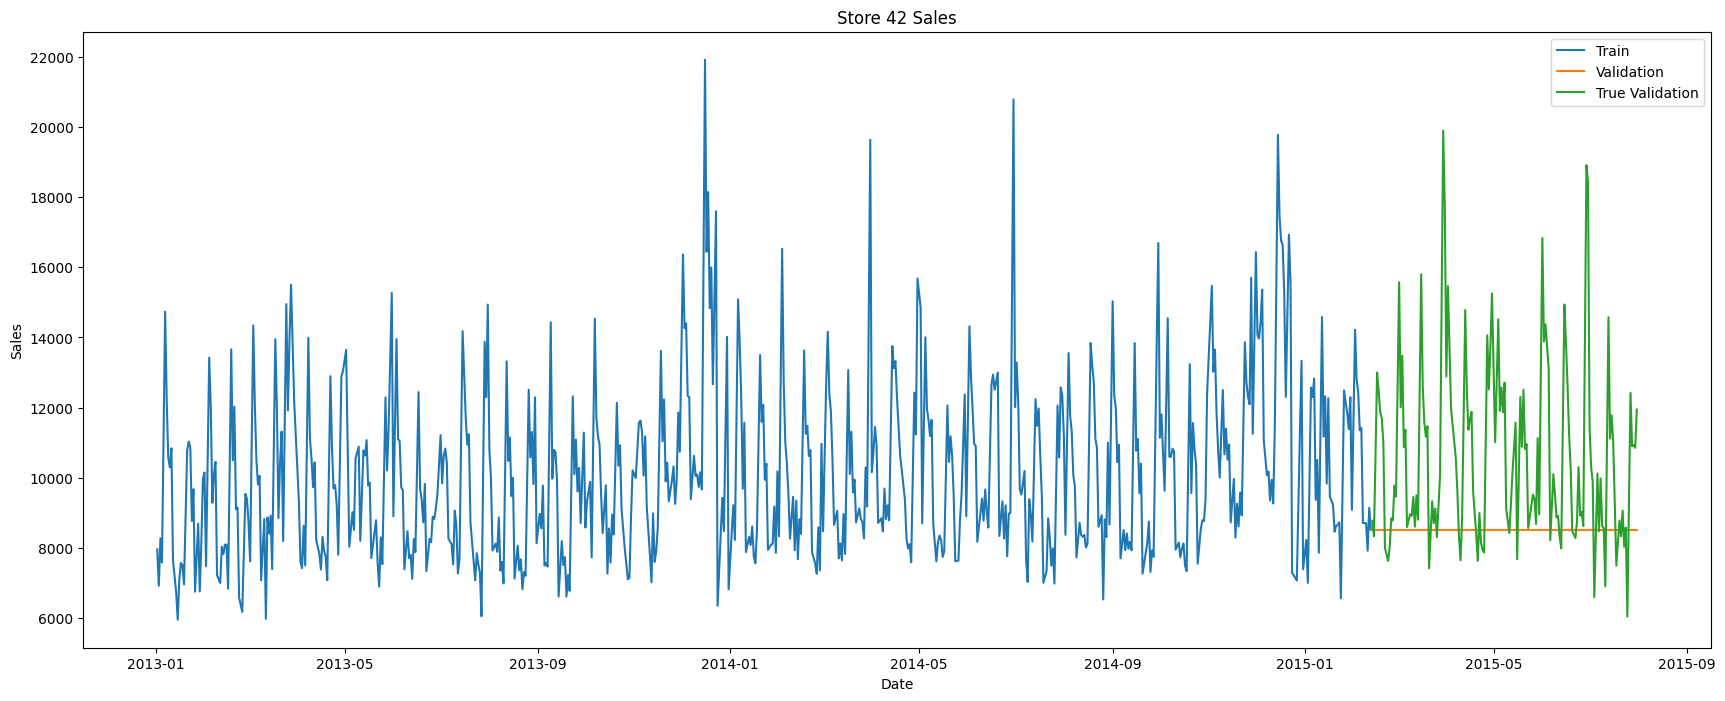

In [12]:
Plot_train_validation(train_data, naive_predictions, 42 , pred_col_name = 'PredictedSales' , True_valdation = validation_data , Plot_true = True)

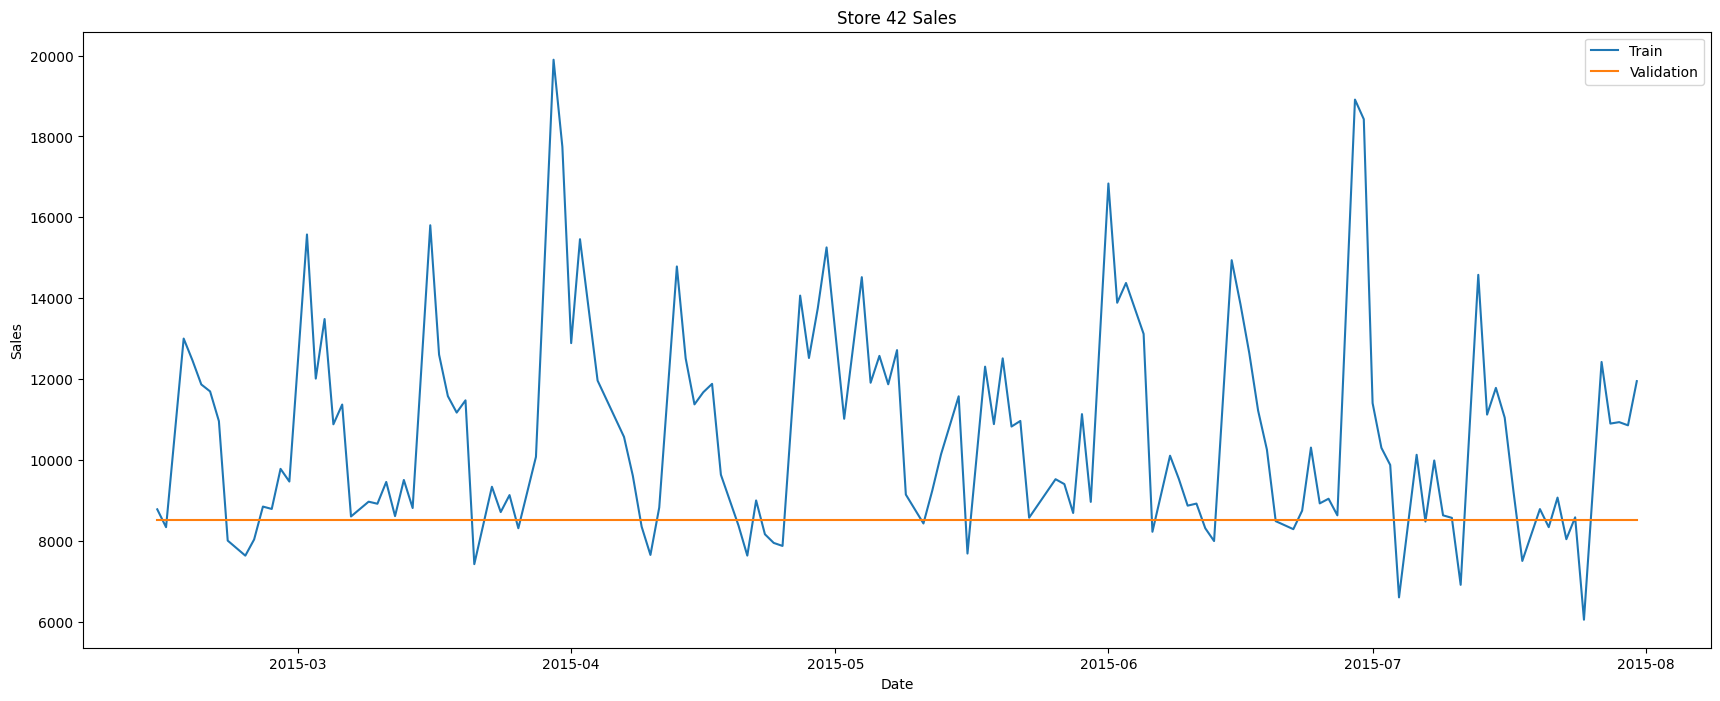

In [69]:
Plot_train_validation(validation_data, naive_predictions, 42 , pred_col_name = 'PredictedSales' )

### Average Forecast

In [82]:
average_predictions = average_method(train_data, validation_data)
rmspe(validation_data['Sales'] + 1 , average_predictions['PredictedSales'])

0.27126569911725784

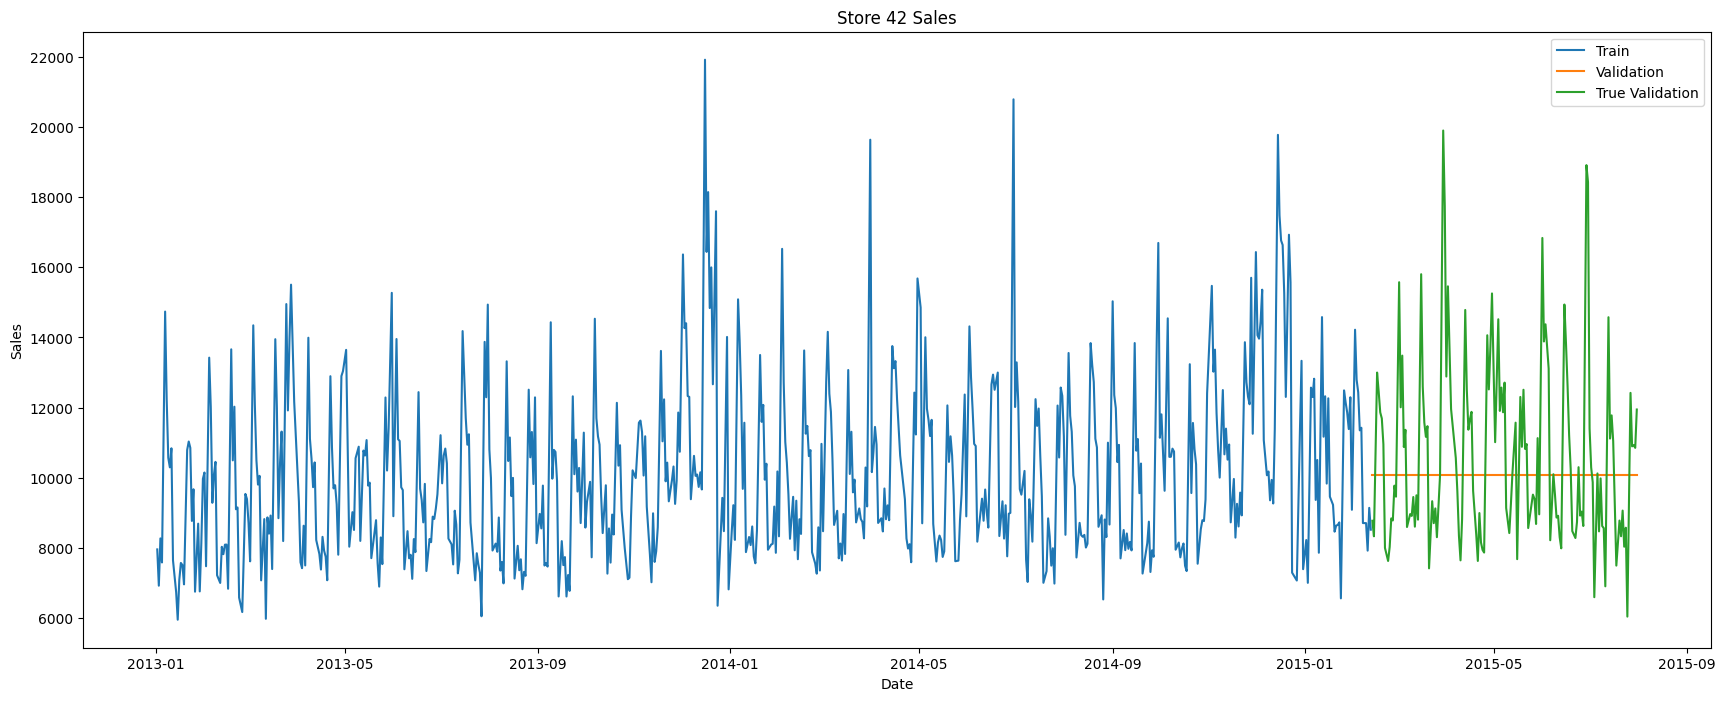

In [14]:
Plot_train_validation(train_data, average_predictions, 42 , pred_col_name = 'PredictedSales', True_valdation = validation_data , Plot_true = True)

### Drift Forecast

In [84]:
drift_pred = drift_method(train_data,validation_data)
rmspe(validation_data['Sales'] , drift_pred['PredictedSales'])

0.39119685718274777

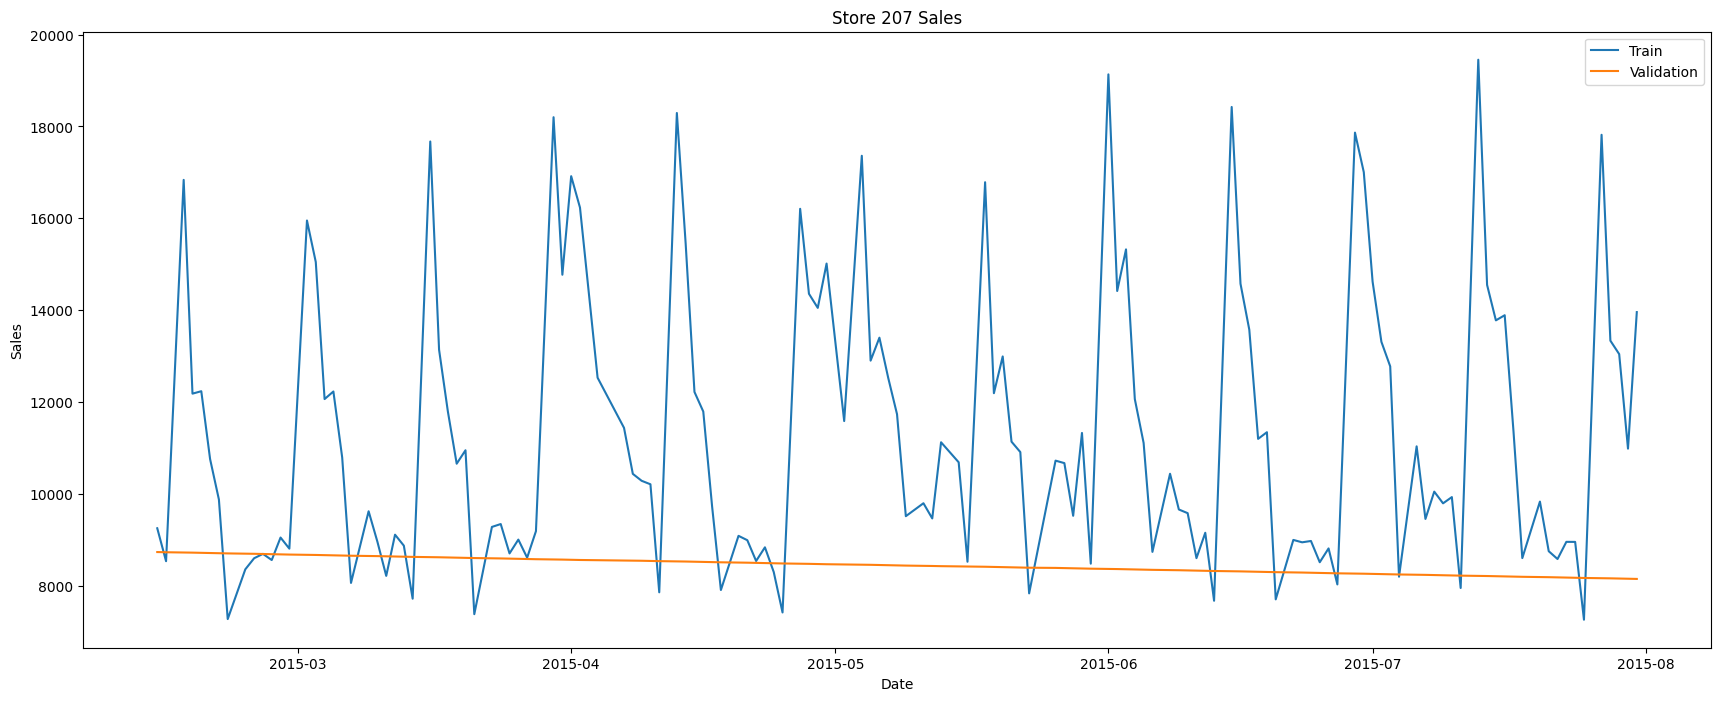

In [20]:
Plot_train_validation(validation_data, drift_pred, 207 , pred_col_name = 'PredictedSales' )

## Step 3: ETS Models

In [85]:
train_data = train_data.sort_values(['Store', 'Date'])
validation_data = validation_data.sort_values(['Store', 'Date'])

In [ ]:
Exponential_Smoothing_Pred = Exponential_Smoothing(train_data, validation_data, 42)

In [87]:
rmspe(validation_data[validation_data['Store'] == 42]['Sales'] , Exponential_Smoothing_Pred['PredictedSales'])

0.6594524925095895

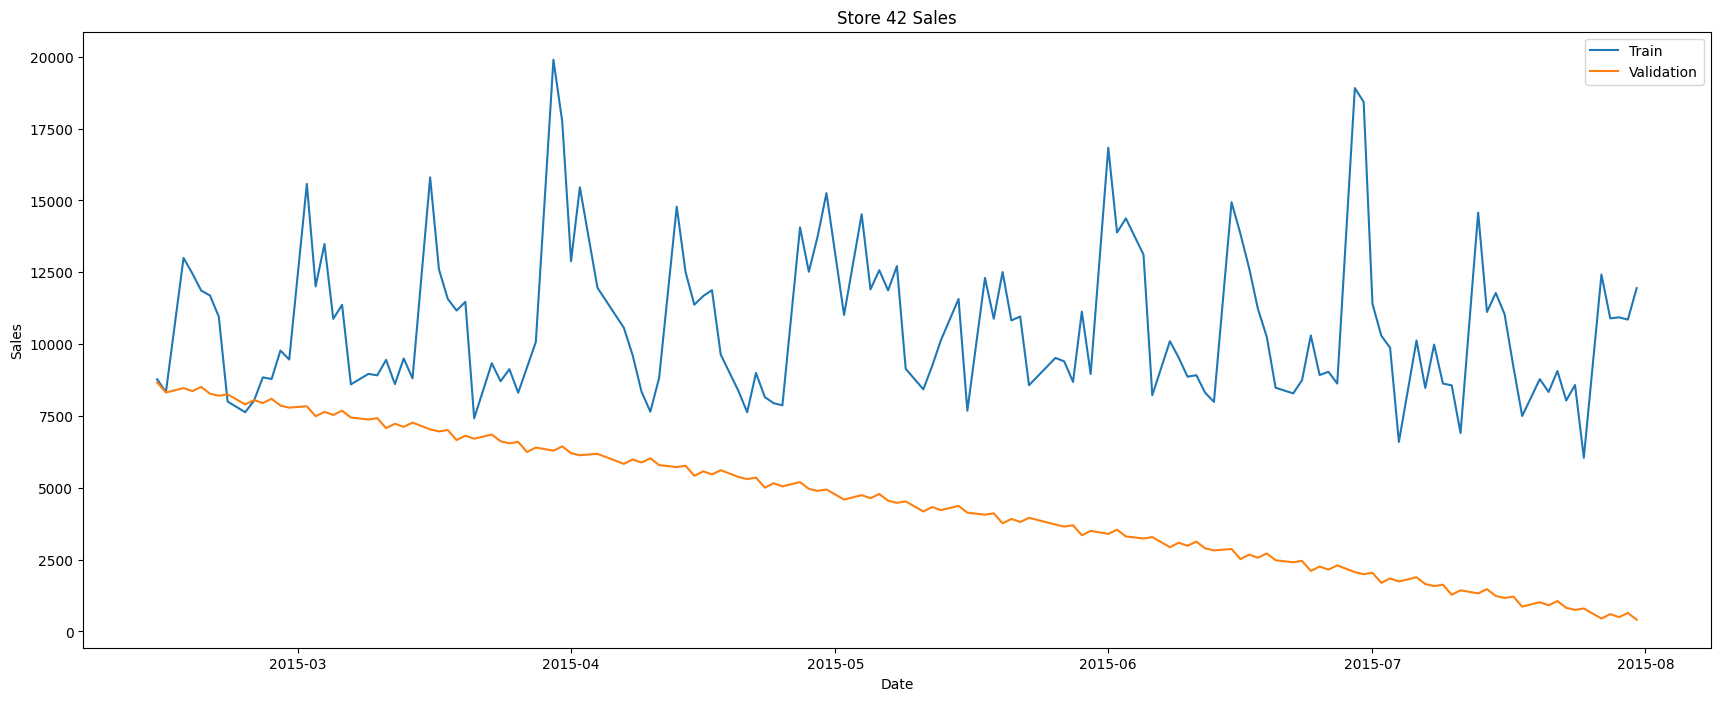

In [57]:
Plot_train_validation(validation_data, Exponential_Smoothing_Pred, 42 , pred_col_name = 'PredictedSales' )

Applay to diffrent store.

In [ ]:
Exponential_Smoothing_Pred = Exponential_Smoothing(train_data, validation_data, 7)

In [90]:
rmspe(validation_data[validation_data['Store'] == 7]['Sales'] , Exponential_Smoothing_Pred['PredictedSales'])

0.40585776113859406

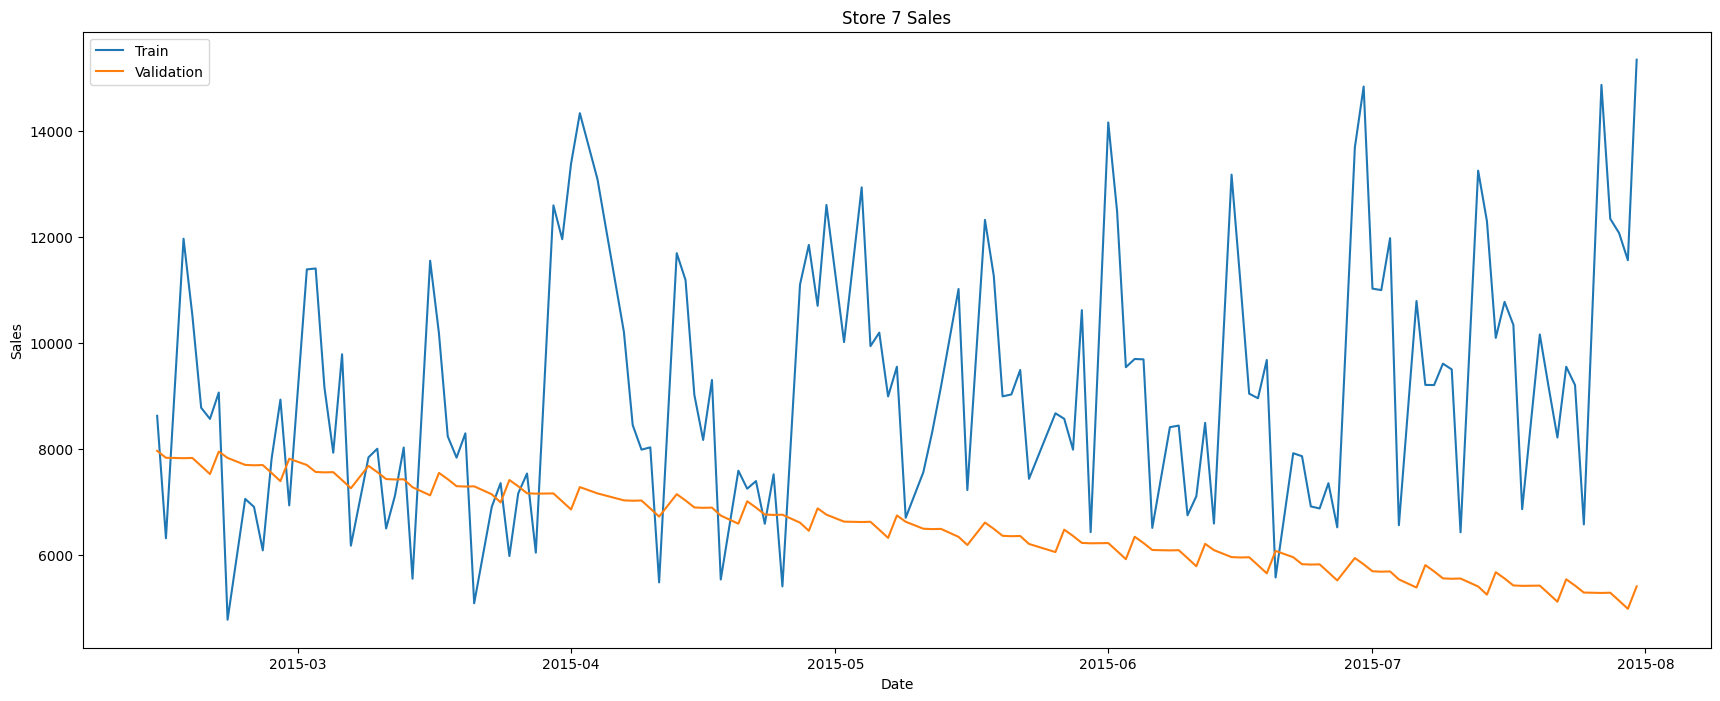

In [64]:
Plot_train_validation(validation_data, Exponential_Smoothing_Pred, 7 , pred_col_name = 'PredictedSales' )

## Step 4: ARIMA Model

ARIMA model is a combination of 3 parts:
- AR: Autoregression. A model that uses the dependent relationship between an observation and some number of lagged observations.
- I: Integrated. The use of differencing of raw observations (e.g. subtracting an observation from an observation at the previous time step) in order to make the time series stationary.
- MA: Moving Average. A model that uses the dependency between an observation and a residual error from a moving average model applied to lagged observations.

ARIMA model can capture the seasonality and trend in the data, so i will use all data even when sales are zero because the store is closed. <br>


In [91]:
train_Sorted = train.sort_values(['Store', 'Date'])
validation_start_date = train_Sorted['Date'].max() - pd.Timedelta(weeks=24)
train_data = train_Sorted[train_Sorted['Date'] < validation_start_date]
validation_data = train_Sorted[train_Sorted['Date'] >= validation_start_date]

Let's applay ARIMA model to the store number 1.<br>

In [92]:
train_sales = get_store_data_ARIMA(train_data , 1)
test_sales  = get_store_data_ARIMA(validation_data , 1)

Text(0.5, 1.0, 'Rolling Mean & Standard Deviation')

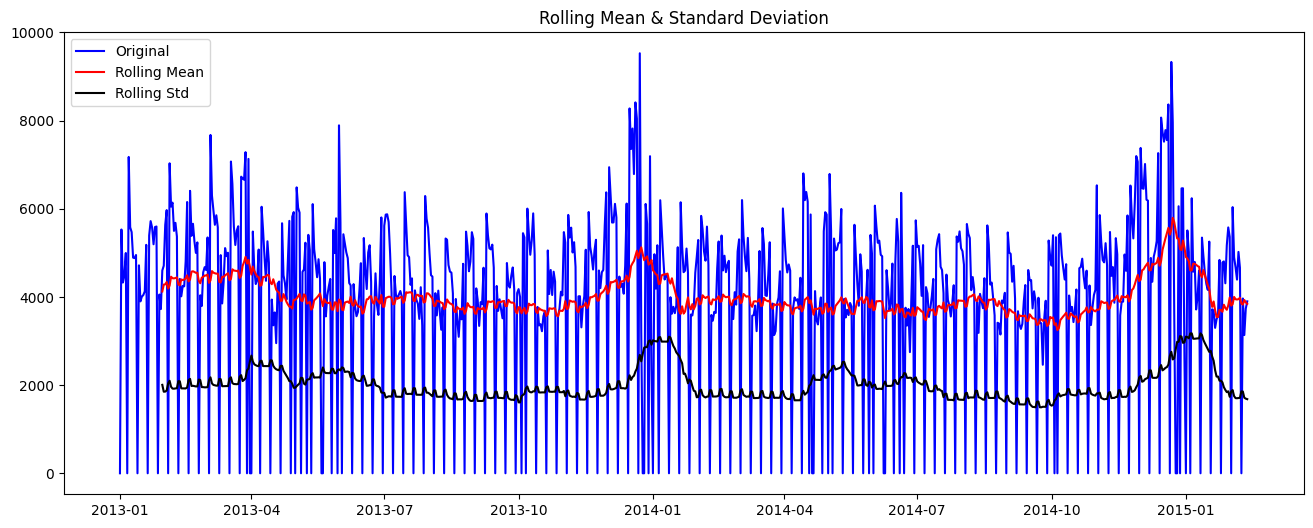

In [280]:
fig ,axes =plt.subplots(1,1)
fig.set_figheight(6)
fig.set_figwidth(16)

#Determing rolling statistics
rolmean = train_sales[["Sales"]].rolling( window=30).mean()
rolstd = train_sales[["Sales"]].rolling(window=30).std()

#Plot rolling statistics:
orig = axes.plot(train_sales[["Sales"]], color='blue',label='Original')
mean = axes.plot(rolmean, color='red', label='Rolling Mean')
std = axes.plot(rolstd, color='black', label = 'Rolling Std')
axes.legend(loc='best')
axes.set_title('Rolling Mean & Standard Deviation')

In [281]:
adf_test(train_sales[['Sales']])

ADF Statistic: -4.04952162285335
p-value: 0.0011722846994950912
Critical Values:
	1%: -3.4390874066174355
	5%: -2.8653962034740705
	10%: -2.568823449196012
Conclusion:====>
Reject the null hypothesis
Data is stationary


In [437]:
kpss_test(train_sales[['Sales']])

KPSS Statistic: 0.2019659250129065
p-value: 0.1
Lags Used: 3
Critical Values:
	10%: 0.347
	5%: 0.463
	2.5%: 0.574
	1%: 0.739
The data is stationary


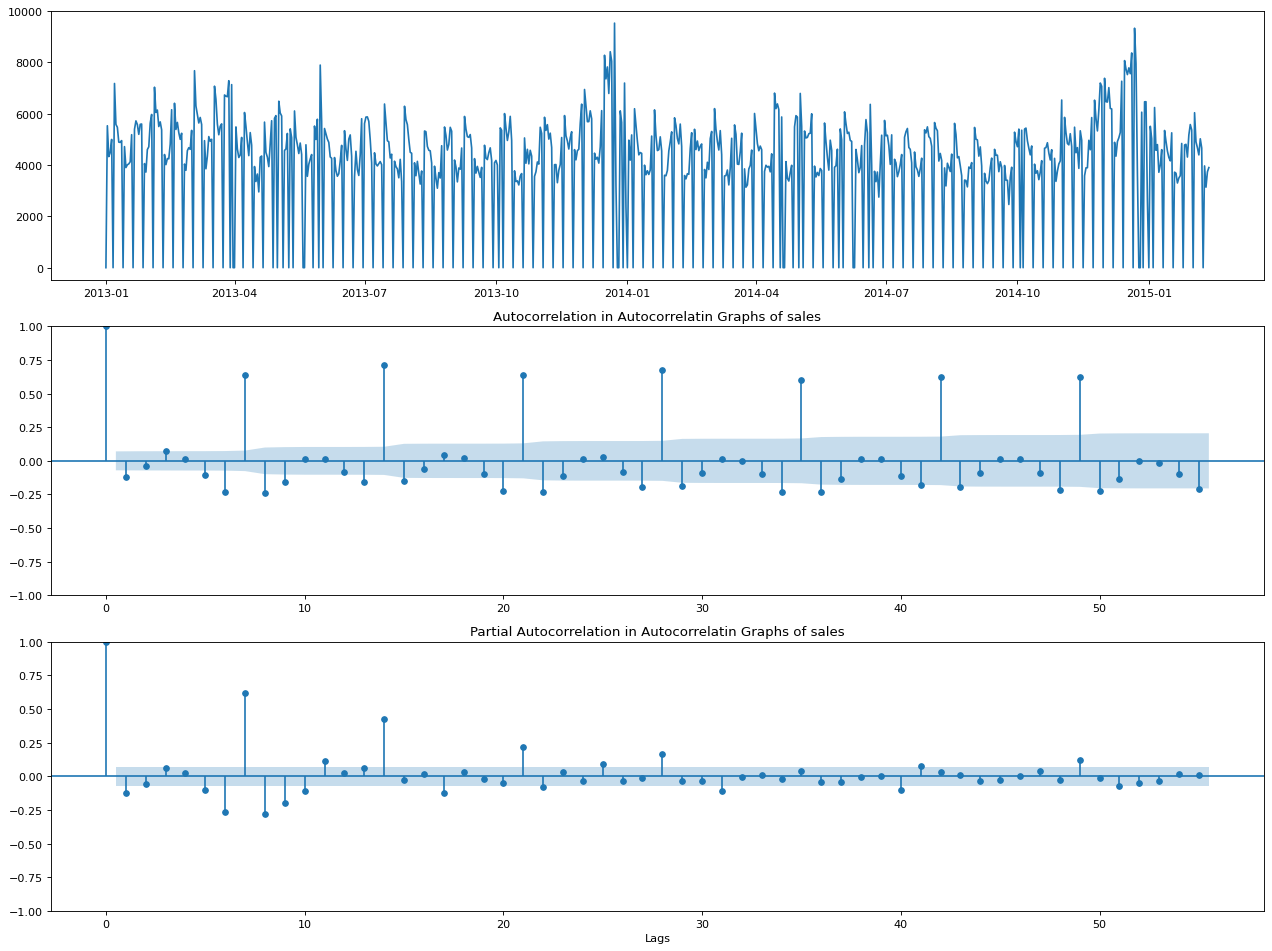

In [283]:
autocorrelatin_graphs(train_sales[["Sales"]], n_lags=55, title_text="Autocorrelatin Graphs of sales")

In [ ]:
ARIMA_model_fit = ARIMA_Model(train_sales[["Sales"]], Order =(1, 0, 1) , Seasonal_order = (1, 0, 1, 7 ))

In [285]:
ARIMA_model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                    SARIMAX Results                                    
=======================================================================================
Dep. Variable:                           Sales   No. Observations:                  773
Model:             ARIMA(1, 0, 1)x(1, 0, 1, 7)   Log Likelihood               -6552.734
Date:                         Sun, 09 Jun 2024   AIC                          13117.468
Time:                                 19:24:57   BIC                          13145.370
Sample:                             01-01-2013   HQIC                         13128.204
                                  - 02-12-2015                                         
Covariance Type:                           opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       3995.7433   4.62e-07   8.65e+09      0.000    3995.743    3995.743
ar.L1          0.6850      0.046     15.015      0.000       0.596       0.774
ma.L1         -0.4369      0.051     -8.559      0.000      -0.537      -0.337
ar.S.L7        1.0000   8.01e-06   1.25e+05      0.000       1.000       1.000
ma.S.L7       -0.9992      0.025    -40.173      0.000      -1.048      -0.950
sigma2      1.284e+06   1.86e-08   6.89e+13      0.000    1.28e+06    1.28e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.58   Jarque-Bera (JB):              1774.09
Prob(Q):                              0.45   Prob(JB):                         0.00
Heteroskedasticity (H):               0.91   Skew:                            -1.36
Prob(H) (two-sided):                  0.43   Kurtosis:                         9.91
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 4.02e+28. Standard errors may be unstable.
"""

`BIC` is so high, indicating that the model is not good. 😅 <br>
To fix this problem, maybe I will apply `auto_arima` function later. <br>

In [94]:
start_index = test_sales.index.min()
end_index = test_sales.index.max()

In [95]:
arima_preds = ARIMA_Predict(ARIMA_model_fit,start_index , end_index )

In [ ]:
arima_forecast = ARIMA_model_fit.forecast(start_index = start_index , end_index = end_index)

In [98]:
rmspe(test_sales[["Sales"]] , arima_preds )

0.31057847267587485

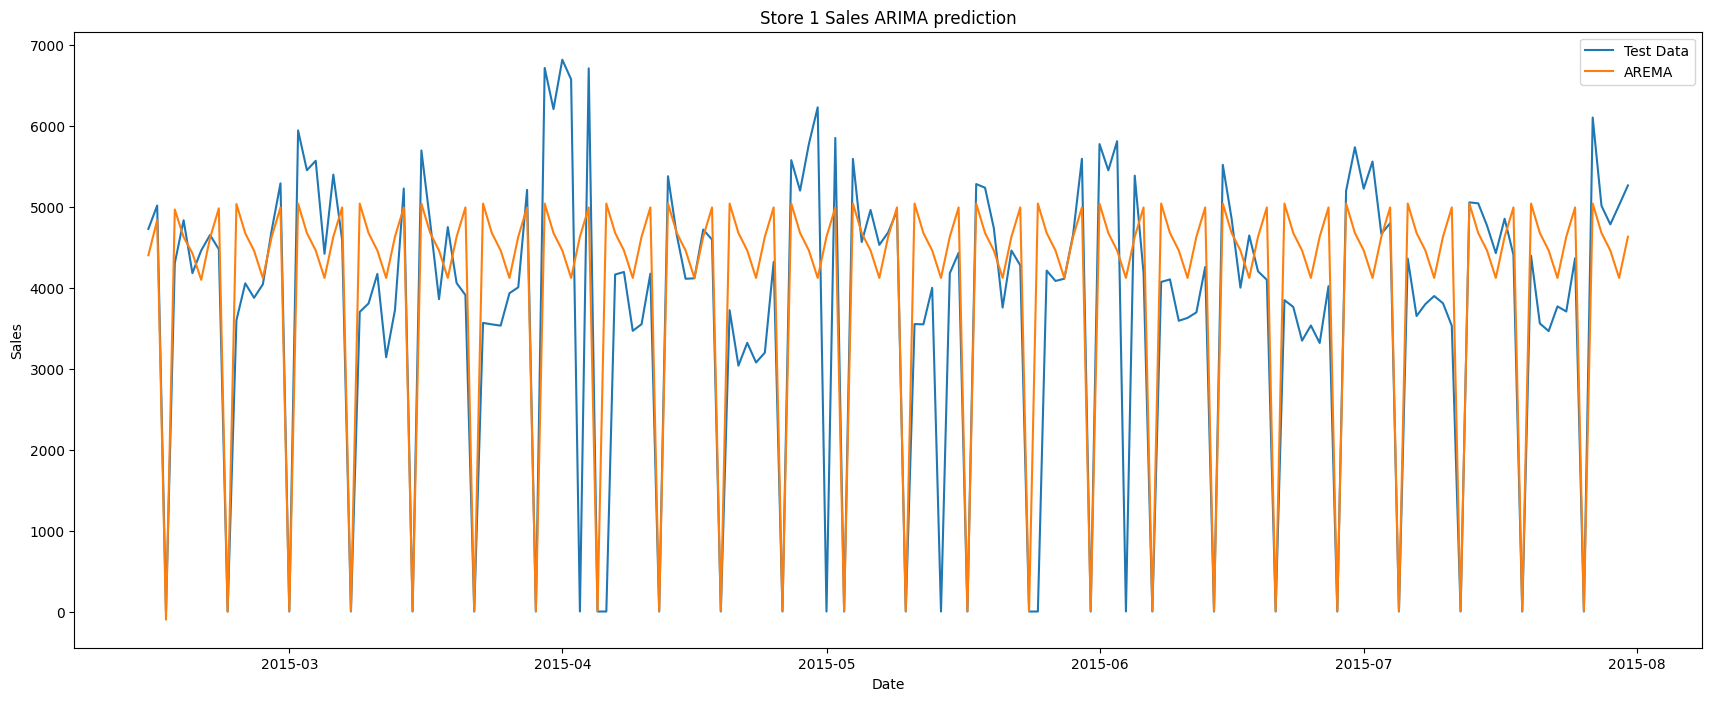

In [290]:
Plot_train_validation_AREMA(test_sales, arima_preds, 1 )

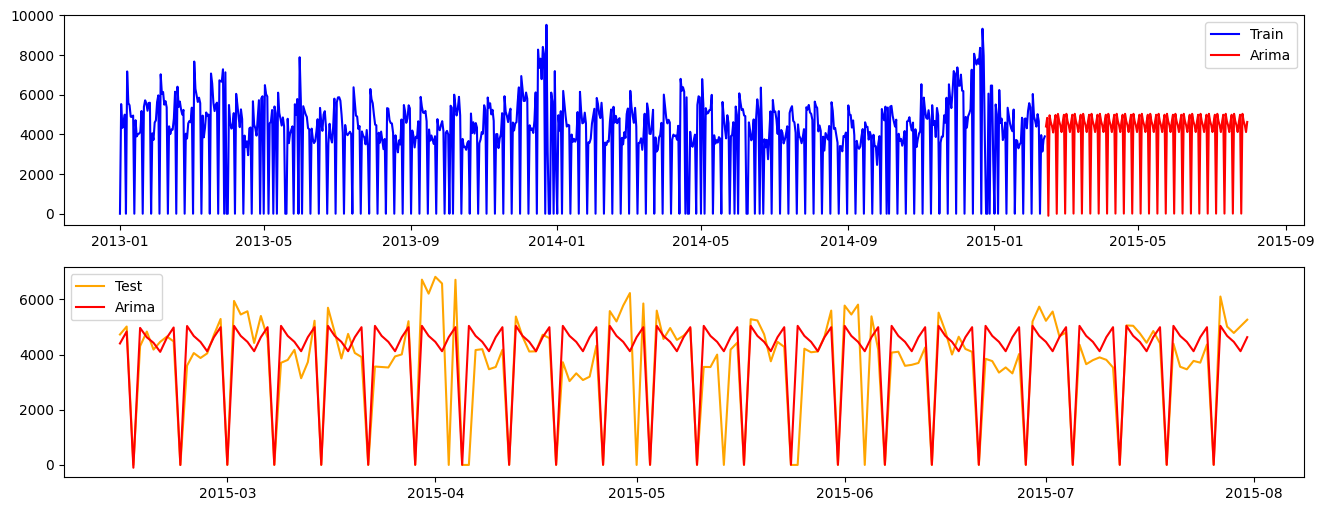

In [291]:
fig ,axes =plt.subplots(2,1)
fig.set_figheight(6)
fig.set_figwidth(16)

axes[0].plot(train_sales[['Sales']], label='Train',color='blue')
# axes[0].plot(test_sales[['Sales']].values, label='Test',color='orange')

axes[0].plot(arima_preds,label="Arima",color='red')
axes[0].legend(loc='best')

axes[1].plot(test_sales[["Sales"]], label='Test',color='orange')
axes[1].plot(arima_preds,label="Arima",color='red')
axes[1].legend(loc='best')
plt.show()

Let's Tray ARIMA model on some random stores. <br>

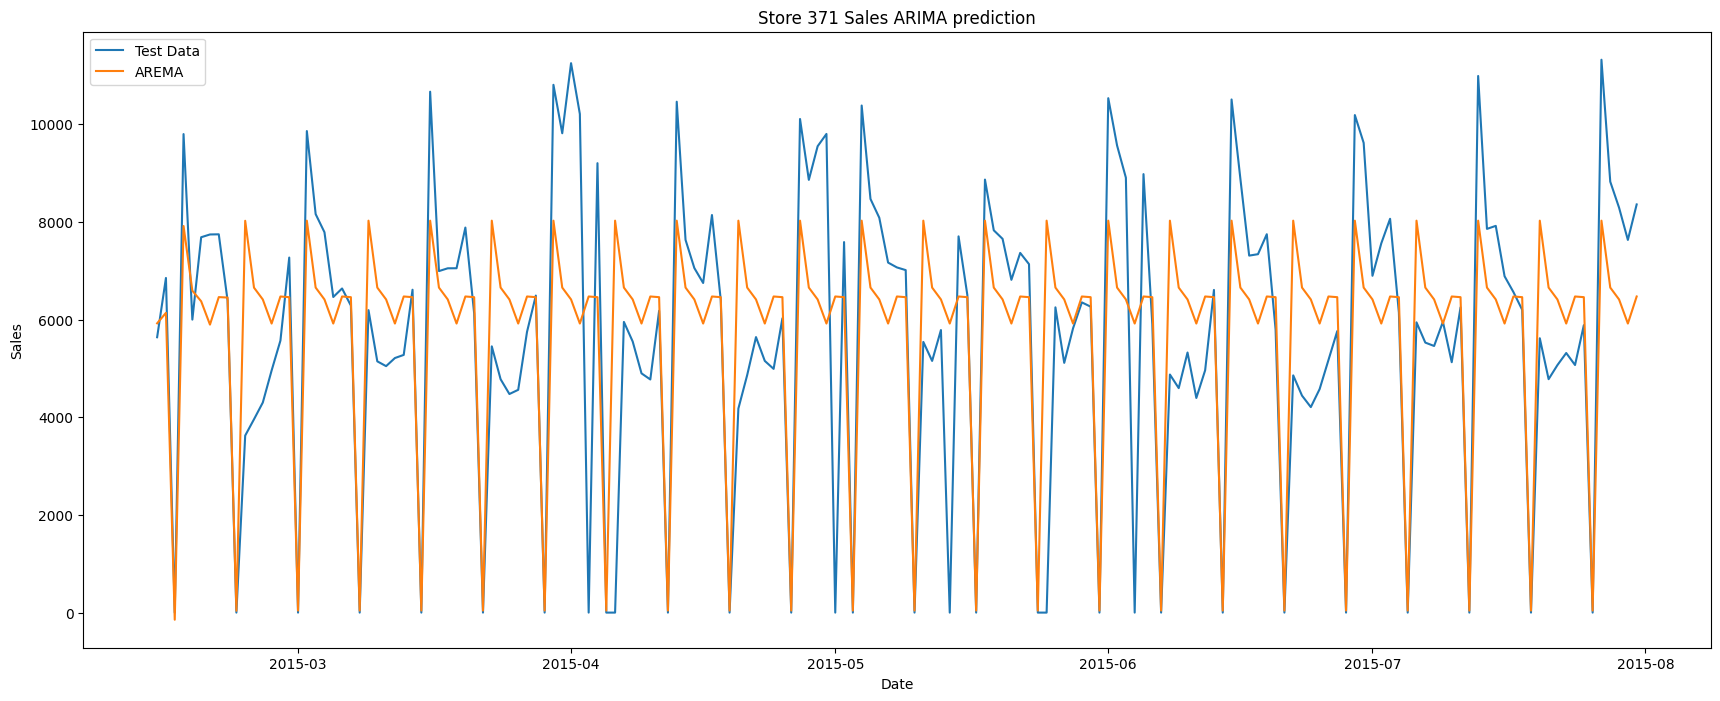

RMSPE for store 371 is 0.3625223476700154


In [433]:
score  = Applay_ARIMA_To_Store(371 , train_data , validation_data , (1, 0, 1) , (1, 0, 1, 7 ) , Plot = True)
print(f"RMSPE for store 371 is {score}")

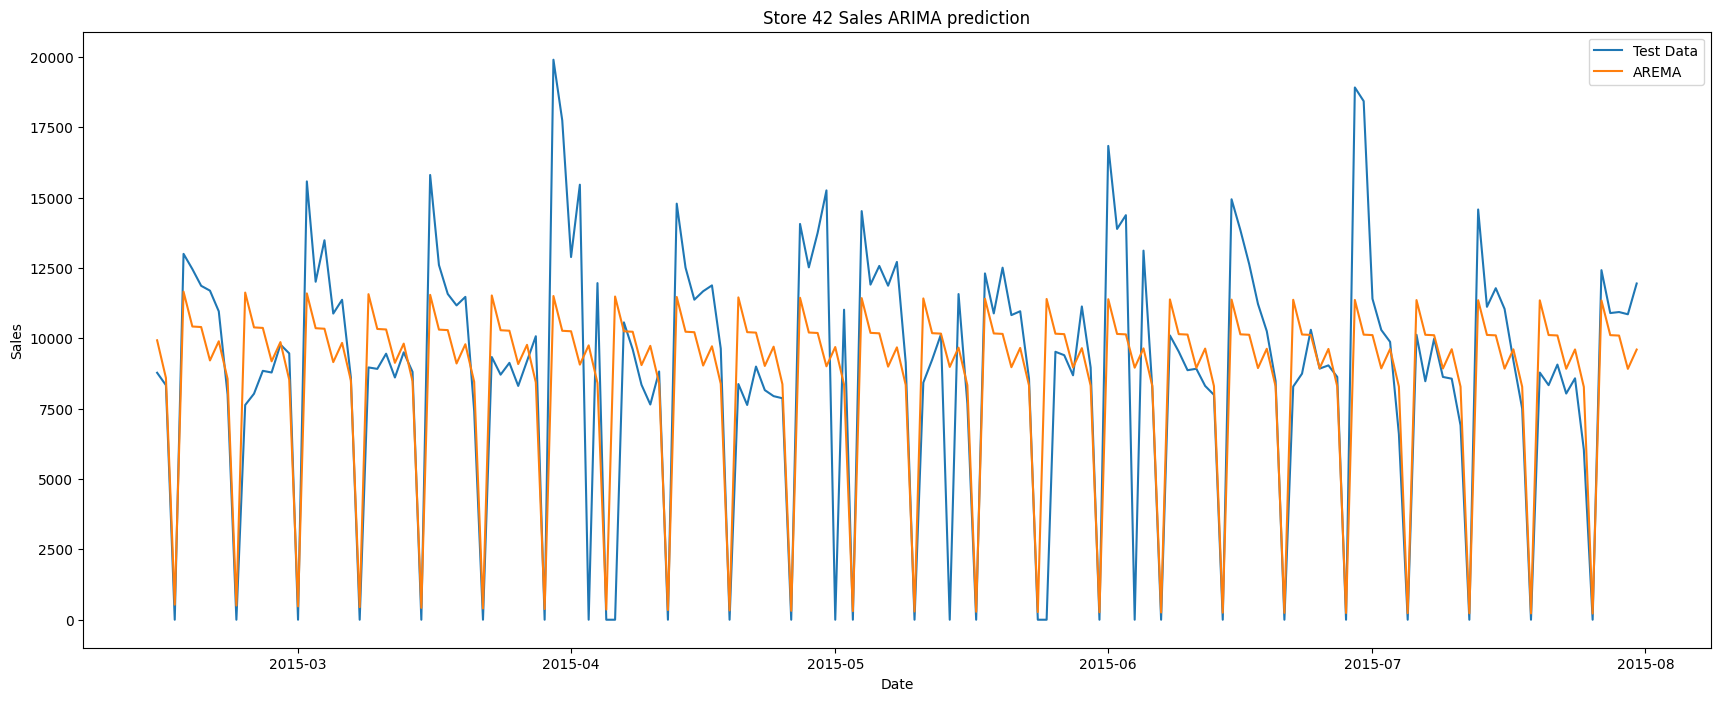

RMSPE for store 371 is 0.3345226139683735


In [434]:
score  = Applay_ARIMA_To_Store(42 , train_data , validation_data , (1, 0, 1) , (1, 0, 1, 7 ) , Plot = True)
print(f"RMSPE for store 371 is {score}")

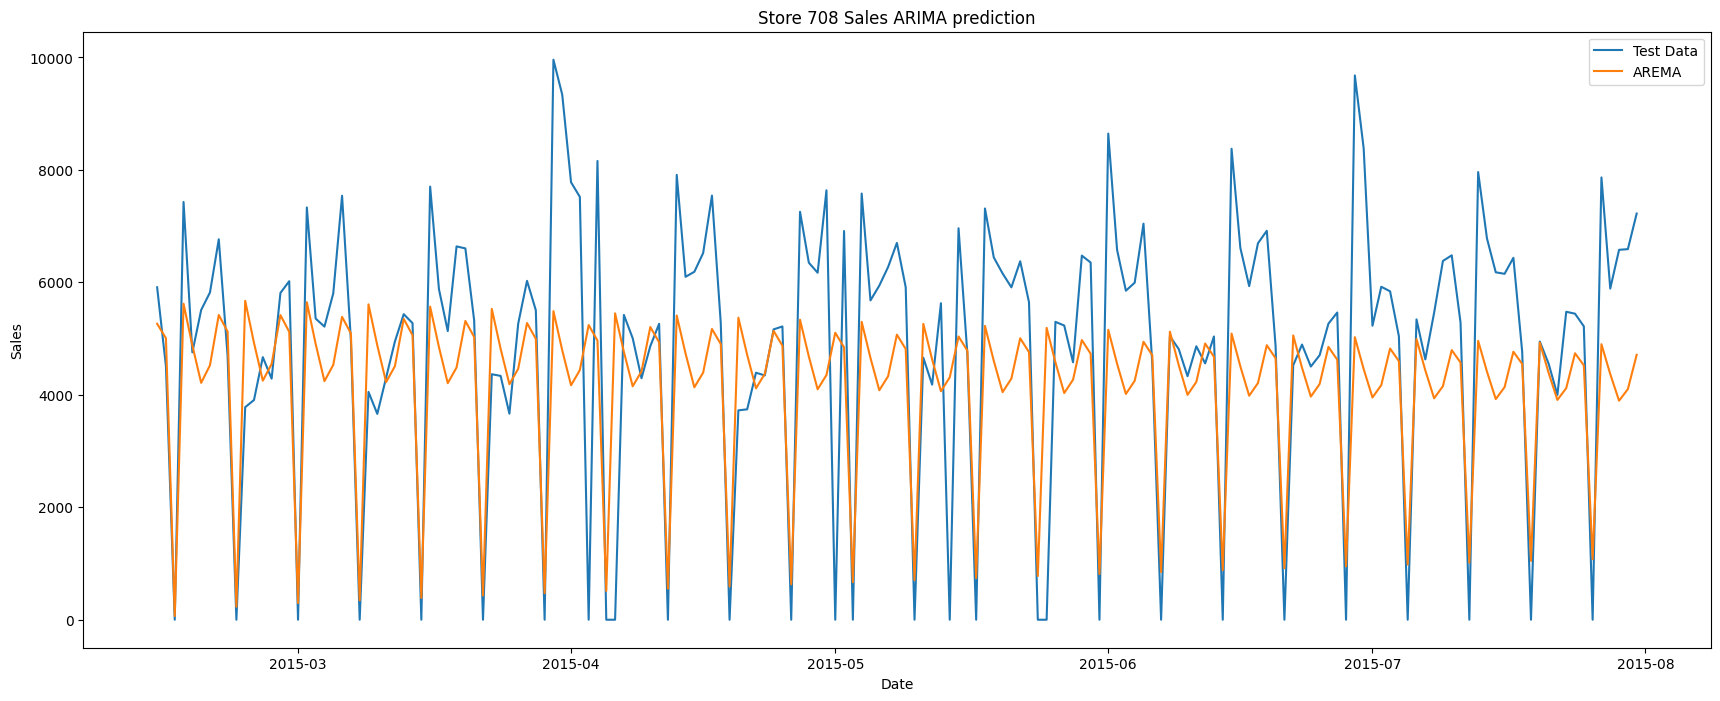

RMSPE for store 371 is 0.36962225692330813


In [435]:
score  = Applay_ARIMA_To_Store(708 , train_data , validation_data , (1, 0, 1) , (1, 0, 1, 7 ) , Plot = True)
print(f"RMSPE for store 371 is {score}")

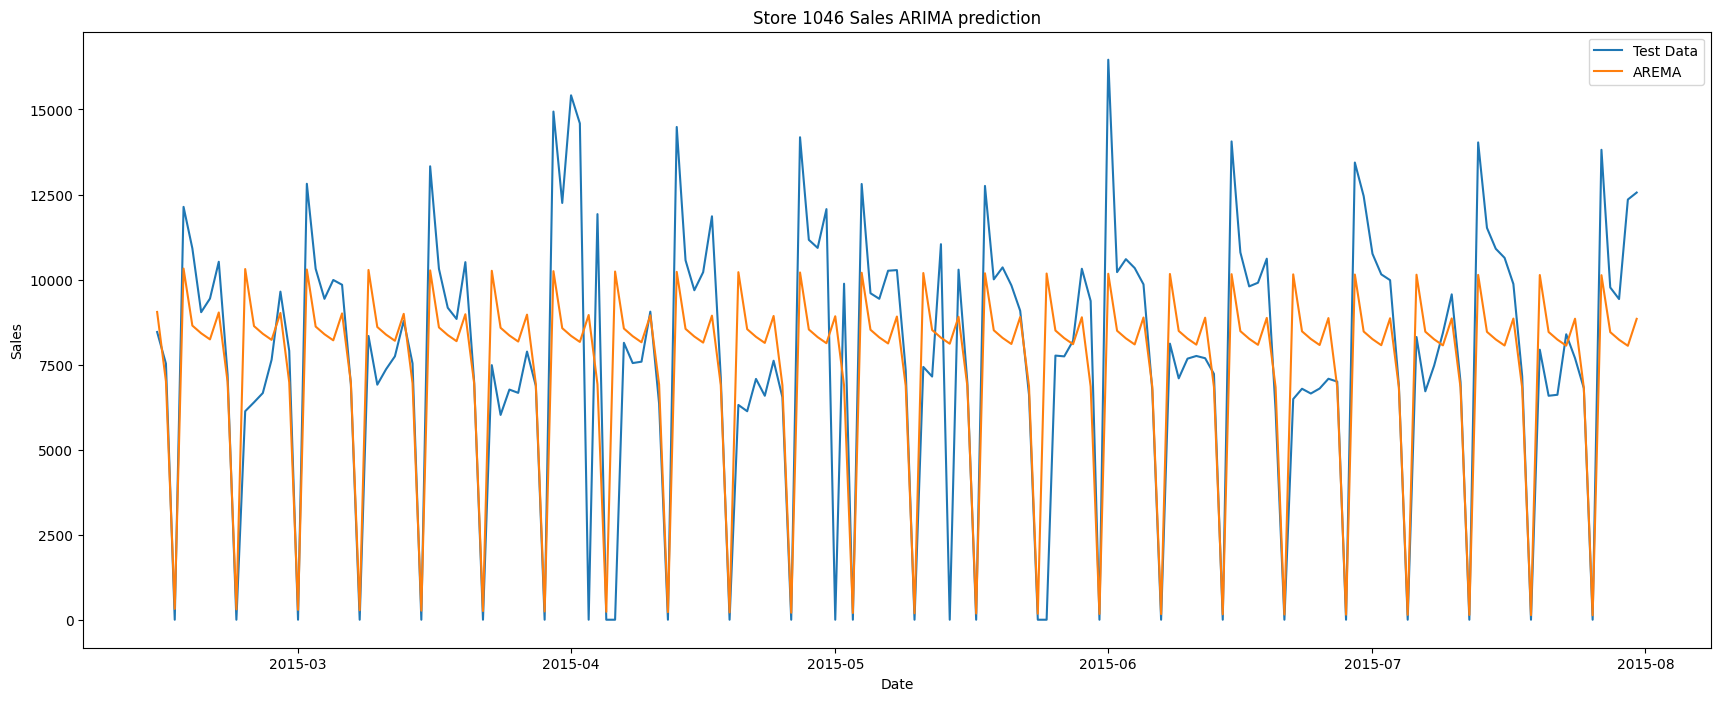

RMSPE for store 371 is 0.33832118295766395


In [436]:
score  = Applay_ARIMA_To_Store(1046 , train_data , validation_data , (1, 0, 1) , (1, 0, 1, 7 ) , Plot = True)
print(f"RMSPE for store 371 is {score}")

## Step 5: Prophet (Facebook) Model 
With a `True` weekly_seasonality and `multiplicative` seasonality_mode, yealds a slightly better model in terms of RMSPE. <br>

Apply Prophet model to the store number 1. <br>

02:10:05 - cmdstanpy - INFO - Chain [1] start processing
02:10:05 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\hp\AppData\Local\Programs\Python\Python311\Lib\site-packages\prophet\plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
c:\Users\hp\AppData\Local\Programs\Python\Python311\Lib\site-packages\prophet\plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


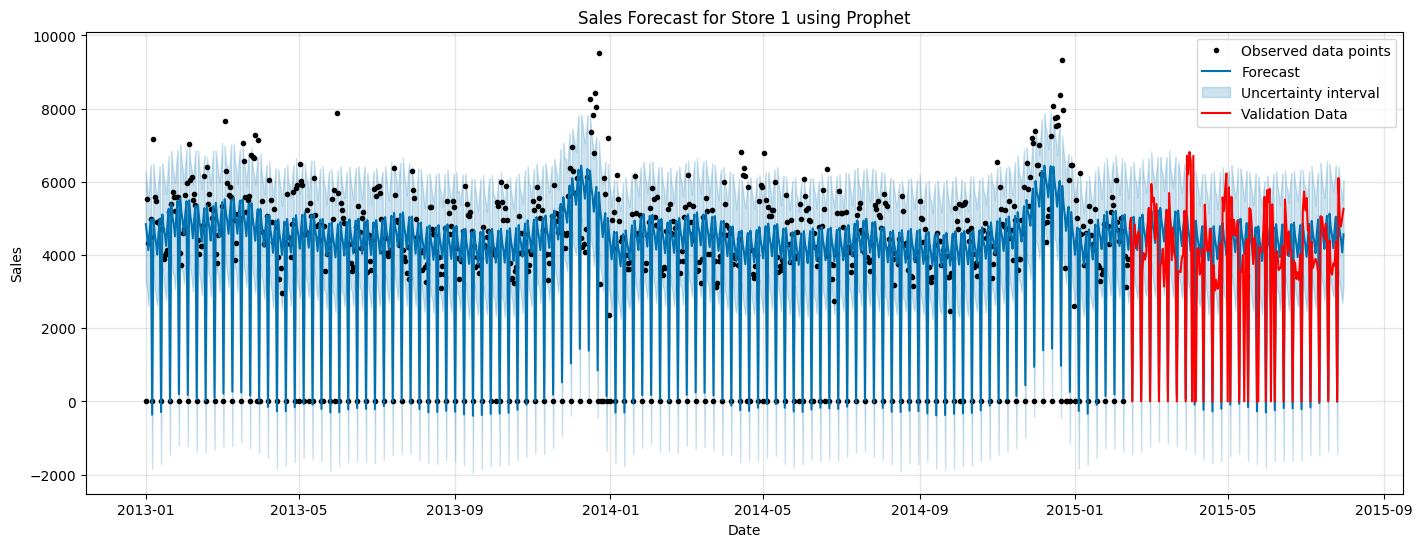

RMSPE for store 1 is 0.3065182780603724


In [103]:
prophet_predictions , score = prophet_forecast(train_data, validation_data, store_number=1)
print(f"RMSPE for store 1 is {score}")

02:10:12 - cmdstanpy - INFO - Chain [1] start processing
02:10:13 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\hp\AppData\Local\Programs\Python\Python311\Lib\site-packages\prophet\plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
c:\Users\hp\AppData\Local\Programs\Python\Python311\Lib\site-packages\prophet\plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


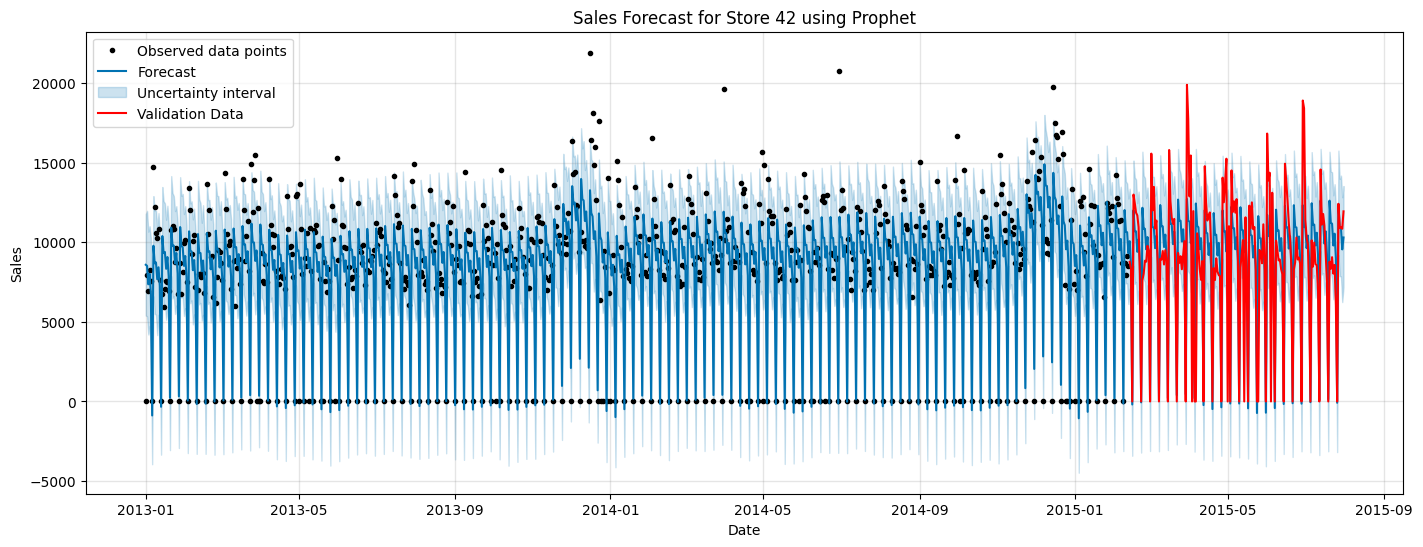

RMSPE for store 42 is 0.333219593131391


In [104]:
prophet_predictions , score = prophet_forecast(train_data, validation_data, store_number=42)
print(f"RMSPE for store 42 is {score}")

02:10:18 - cmdstanpy - INFO - Chain [1] start processing
02:10:18 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\hp\AppData\Local\Programs\Python\Python311\Lib\site-packages\prophet\plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
c:\Users\hp\AppData\Local\Programs\Python\Python311\Lib\site-packages\prophet\plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


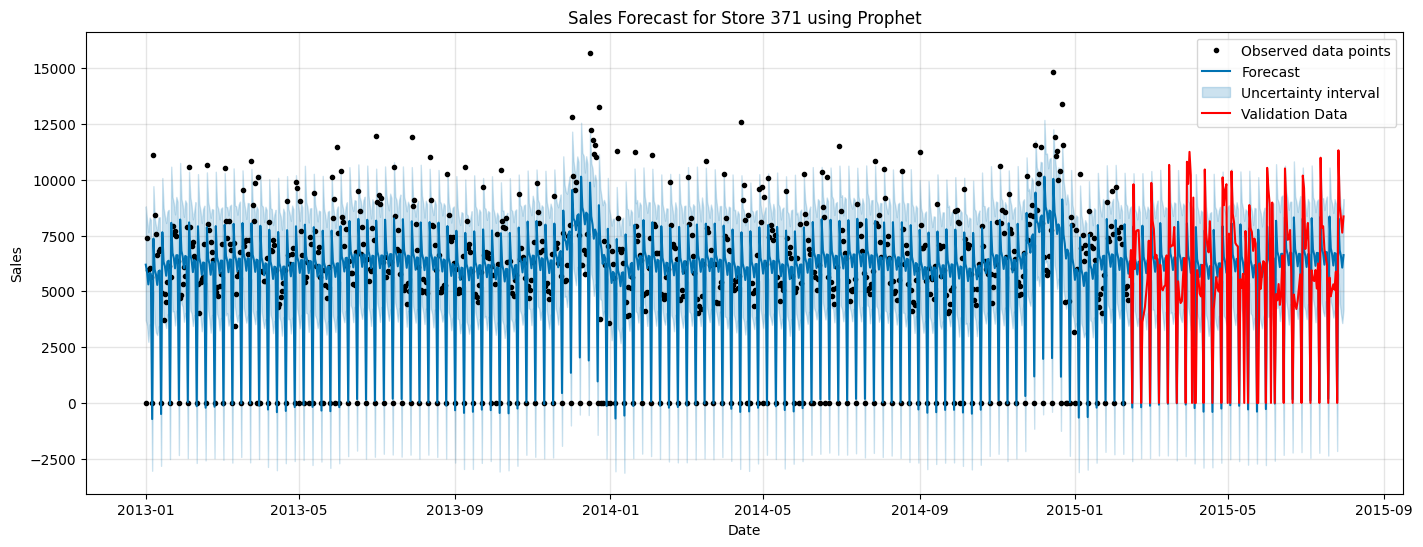

RMSPE for store 371 is 0.3626335772774462


In [105]:
prophet_predictions , score = prophet_forecast(train_data, validation_data, store_number=371)
print(f"RMSPE for store 371 is {score}")

## Step 6: Machine Learning Model

To use machine learning models on time series data, we need to create some features that can carry the sequencial nature of the data ( Time dependant patterns ). <br>
we need to create some features from the date column that can help the model to capture the time dependant patterns. <br>


--- 
- Assortment - describes an assortment level: a = basic, b = extra, c = extended
- CompetitionDistance - distance in meters to the nearest competitor store
- CompetitionOpenSince[Month/Year] - gives the approximate year and month of the time the nearest competitor was opened
- Promo - indicates whether a store is running a promo on that day
- Promo2 - Promo2 is a continuing and consecutive promotion for some stores: 0 = store is not participating, 1 = store is participating
- Promo2Since[Year/Week] - describes the year and calendar week when the store started participating in Promo2
- PromoInterval - describes the consecutive intervals Promo2 is started, naming the months the promotion is started anew. E.g. "Feb,May,Aug,Nov" means each round starts in February, May, August, November of any given year for that store.

---

In [405]:
train = pd.read_csv(r'Data\train.csv' , parse_dates = True , low_memory = False)
test =  pd.read_csv(r'Data\test.csv'  , parse_dates = True , low_memory = False)
store = pd.read_csv(r'Data\store.csv')


In [295]:
store.head()

Store StoreType Assortment  CompetitionDistance  CompetitionOpenSinceMonth  \
0      1         c          a               1270.0                        9.0   
1      2         a          a                570.0                       11.0   
2      3         a          a              14130.0                       12.0   
3      4         c          c                620.0                        9.0   
4      5         a          a              29910.0                        4.0   

   CompetitionOpenSinceYear  Promo2  Promo2SinceWeek  Promo2SinceYear  \
0                    2008.0       0              NaN              NaN   
1                    2007.0       1             13.0           2010.0   
2                    2006.0       1             14.0           2011.0   
3                    2009.0       0              NaN              NaN   
4                    2015.0       0              NaN              NaN   

     PromoInterval  
0              NaN  
1  Jan,Apr,Jul,Oct  
2  Jan,Apr,Jul,Oct  
3              NaN  
4              NaN

In [296]:
store.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1115 entries, 0 to 1114
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Store                      1115 non-null   int64  
 1   StoreType                  1115 non-null   object 
 2   Assortment                 1115 non-null   object 
 3   CompetitionDistance        1112 non-null   float64
 4   CompetitionOpenSinceMonth  761 non-null    float64
 5   CompetitionOpenSinceYear   761 non-null    float64
 6   Promo2                     1115 non-null   int64  
 7   Promo2SinceWeek            571 non-null    float64
 8   Promo2SinceYear            571 non-null    float64
 9   PromoInterval              571 non-null    object 
dtypes: float64(5), int64(2), object(3)
memory usage: 87.2+ KB


In [386]:
store[store['Promo2'] == 0].shape

(544, 10)

In [387]:
1115 - 544

571

I Think that any Null value in the coulmns `Promo2SinceWeek`,  `Promo2SinceYear` and `PromoInterval` means that the store didn't have promo, thus I will fill them with zeros. <br>
coulmns `CompetitionOpenSinceMonth`, and `CompetitionOpenSinceYear` will be dropped because thay have more than 30% missing values and i don't think they will be useful. <br>

In [407]:
# Filling the missing values with the median, thay are only 3 values, no frade of data leakage.
store['CompetitionDistance'] = store['CompetitionDistance'].fillna(store['CompetitionDistance'].median()) 

store['Promo2SinceWeek'] = store['Promo2SinceWeek'].fillna(0)
store['Promo2SinceYear'] = store['Promo2SinceYear'].fillna(0)
store['PromoInterval'] = store['PromoInterval'].fillna(0)

store['PromoInterval'] = store['PromoInterval'].map({0: 0, 'Jan,Apr,Jul,Oct': 1, 'Feb,May,Aug,Nov': 2, 'Mar,Jun,Sept,Dec': 3})

store.drop(['CompetitionOpenSinceYear', 'CompetitionOpenSinceMonth'], axis=1, inplace=True)

We don't have the `Customers` column in the test set, so we can't use it in the model. <br>

In [408]:
train = train.drop('Customers',axis = 1)

##### Mergeing Data

In [409]:
train = train.merge(store, on='Store', how='left')
test = test.merge(store, on='Store', how='left')

train['Date'] = pd.to_datetime(train['Date'])
test['Date'] = pd.to_datetime(test['Date'])

##### Creating Time Features

In [410]:
train['Year'] = train['Date'].dt.year
train['Month'] = train['Date'].dt.month
train['Day'] = train['Date'].dt.day
train['DayOfWeek'] = train['Date'].dt.dayofweek

test['Year'] = test['Date'].dt.year
test['Month'] = test['Date'].dt.month
test['Day'] = test['Date'].dt.day
test['DayOfWeek'] = test['Date'].dt.dayofweek



##### Encoding Categorical Features

- StateHoliday - indicates a state holiday. Normally all stores, with few exceptions, are closed on state holidays. Note that all schools are closed on public holidays and weekends.<br>
`a = public holiday`, `b = Easter holiday`, `c = Christmas`, `0 = None`

In [411]:
# Map the StateHoliday column to numerical values.
train['StateHoliday'] = train['StateHoliday'].map({0: 0, '0': 0, 'a': 1, 'b': 2, 'c': 3})
test['StateHoliday'] = test['StateHoliday'].map({0: 0, '0': 0, 'a': 1, 'b': 2, 'c': 3})

# train['StateHoliday'] = train['StateHoliday'].map({0: 'NoHoliday', '0': 'NoHoliday', 'a': 'PublicHoliday', 'b': 'EasterHoliday', 'c': 'Cristmas'})

- StoreType - differentiates between 4 different store `models: a, b, c, d`

In [412]:
# Map the StoreType column to numerical values.
train['StoreType'] = train['StoreType'].map({'a': 0, 'b': 1, 'c': 2, 'd': 3})
test['StoreType'] = test['StoreType'].map({'a': 0, 'b': 1, 'c': 2, 'd': 3})

- Assortment - describes an assortment level: `a = basic`, `b = extra`, `c = extended`

In [413]:
# Map Assortment column to numerical values.
train['Assortment'] = train['Assortment'].map( { 'a':1 , 'b':2 , 'c':3 })
test['Assortment'] = test['Assortment'].map( { 'a':1 , 'b':2 , 'c':3 })

In [304]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 18 columns):
 #   Column               Non-Null Count    Dtype         
---  ------               --------------    -----         
 0   Store                1017209 non-null  int64         
 1   DayOfWeek            1017209 non-null  int32         
 2   Date                 1017209 non-null  datetime64[ns]
 3   Sales                1017209 non-null  int64         
 4   Open                 1017209 non-null  int64         
 5   Promo                1017209 non-null  int64         
 6   StateHoliday         1017209 non-null  int64         
 7   SchoolHoliday        1017209 non-null  int64         
 8   StoreType            1017209 non-null  int64         
 9   Assortment           1017209 non-null  int64         
 10  CompetitionDistance  1017209 non-null  float64       
 11  Promo2               1017209 non-null  int64         
 12  Promo2SinceWeek      1017209 non-null  float64       
 1

Now The Data is ready for any machine learning model. <br>
`Note:` I will drop the `Date` column but after I split the data into train and test sets. <br>

#### Adding some Lag Features

I will add some lag features to the data to help the model to capture the time dependant patterns. <br>
- `Lag 3` features will be the `Sales` of the previous 3 days.
- `Lag 7` features will be the `Customers` of the previous 7 days.
- `Lag 3` features will be the `Open` of the previous 3 days.


In [415]:
train = create_lag_features(train,'DayOfWeek',n_lags=4)
train = create_lag_features(train,'SchoolHoliday',n_lags=4)
train = create_lag_features(train,'Open',n_lags=4)
train = train.dropna()

In [416]:
test = create_lag_features(test,'DayOfWeek',n_lags=4)
test = create_lag_features(test,'SchoolHoliday',n_lags=4)
test = create_lag_features(test,'Open',n_lags=4)

# At test we can't drop nulls because it can distroy the order of the data when making the submission file.


test.fillna(0,inplace=True)

In [308]:
train.columns

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Open', 'Promo', 'StateHoliday',
       'SchoolHoliday', 'StoreType', 'Assortment', 'CompetitionDistance',
       'Promo2', 'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval', 'Year',
       'Month', 'Day', 'DayOfWeekLag_1', 'DayOfWeekLag_2', 'DayOfWeekLag_3',
       'SchoolHolidayLag_1', 'SchoolHolidayLag_2', 'SchoolHolidayLag_3',
       'OpenLag_1', 'OpenLag_2', 'OpenLag_3'],
      dtype='object')

#### Train Test Split

In [417]:
train_Sorted = train.sort_values(['Store', 'Date'])

validation_start_date = train_Sorted['Date'].max() - pd.Timedelta(weeks=24)
train_data = train_Sorted[train_Sorted['Date'] < validation_start_date]
validation_data = train_Sorted[train_Sorted['Date'] >= validation_start_date]

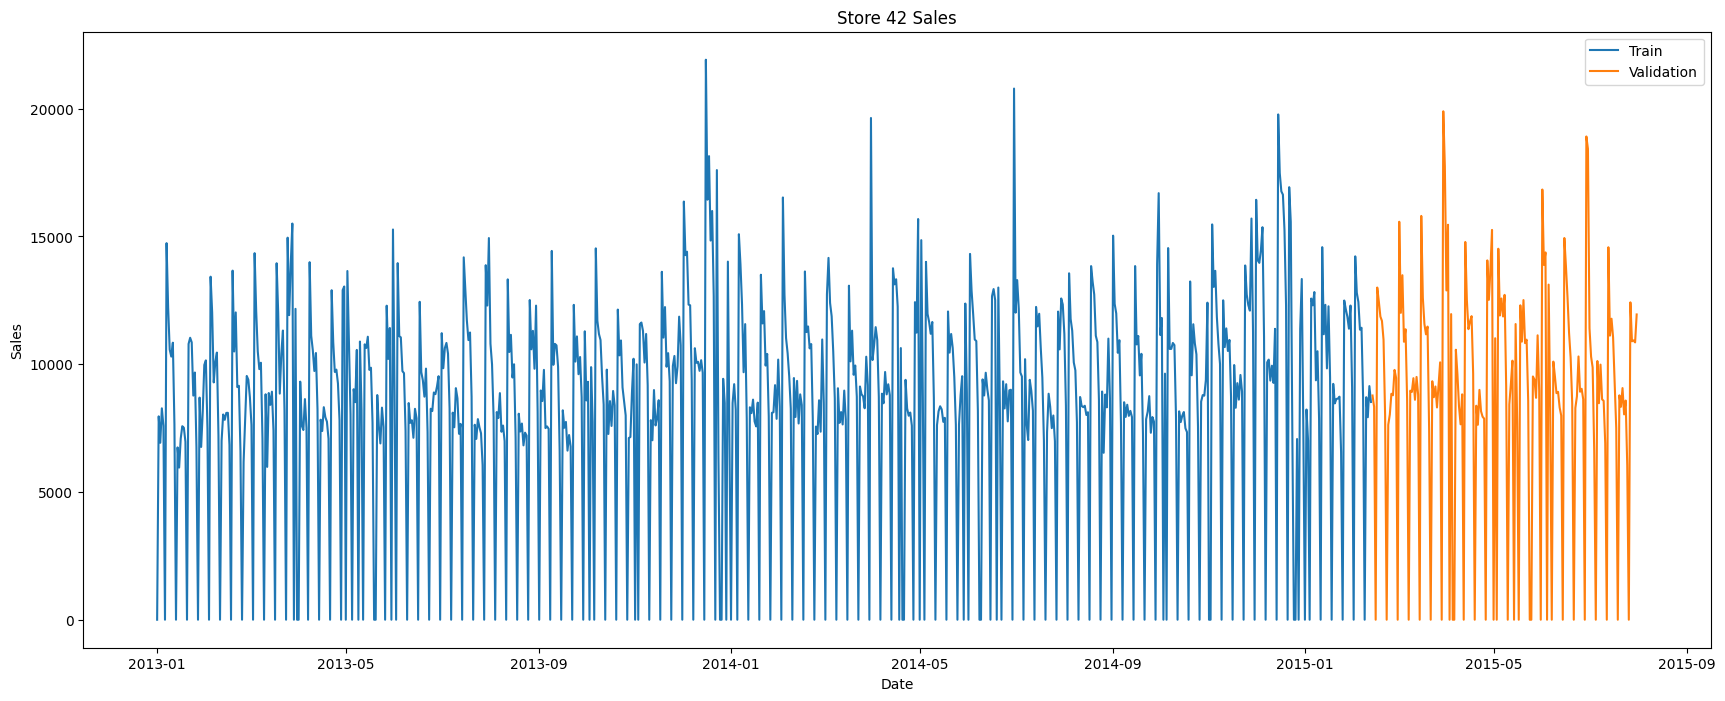

In [311]:
# plot the data for store 42
Plot_train_validation(train_data, validation_data, 42)

In [162]:
# Now we can drop the Date column.
# train_data = train_data.drop('Date', axis=1)
# validation_data = validation_data.drop('Date', axis=1)

#### Modelling

There are too methods that i can tray one is by using the `Store` column as a feature and train one model for all stores, and the other is to train a model for each store. <br>
I will start by training a model for each store. <br>

In [365]:
# Gitting the store data for store 42
store_42_train = get_all_store_data(train_data, 42)
store_42_validation = get_all_store_data(validation_data, 42)

X_train_42 = store_42_train.drop(columns=['Sales' , 'Date','Store'], axis=1)
y_train_42 = store_42_train['Sales']

X_val_42 = store_42_validation.drop(columns=['Sales' , 'Date' , 'Store'], axis=1)
y_val_42 = store_42_validation['Sales']

X_train_42.shape, y_train_42.shape, X_val_42.shape, y_val_42.shape

((773, 24), (773,), (169, 27), (169,))

#### DecisionTreeRegressor

In [328]:
tree_O = DecisionTreeRegressor(max_depth=12, random_state=42, min_samples_split=2, min_samples_leaf=1, max_features=None)

tree_O.fit(X_train_42, y_train_42)

preds = tree_O.predict(X_val_42)
rmspe(y_val_42 , preds)

0.183028925064722

In [329]:
store_42_validation["Model_pred"] = preds

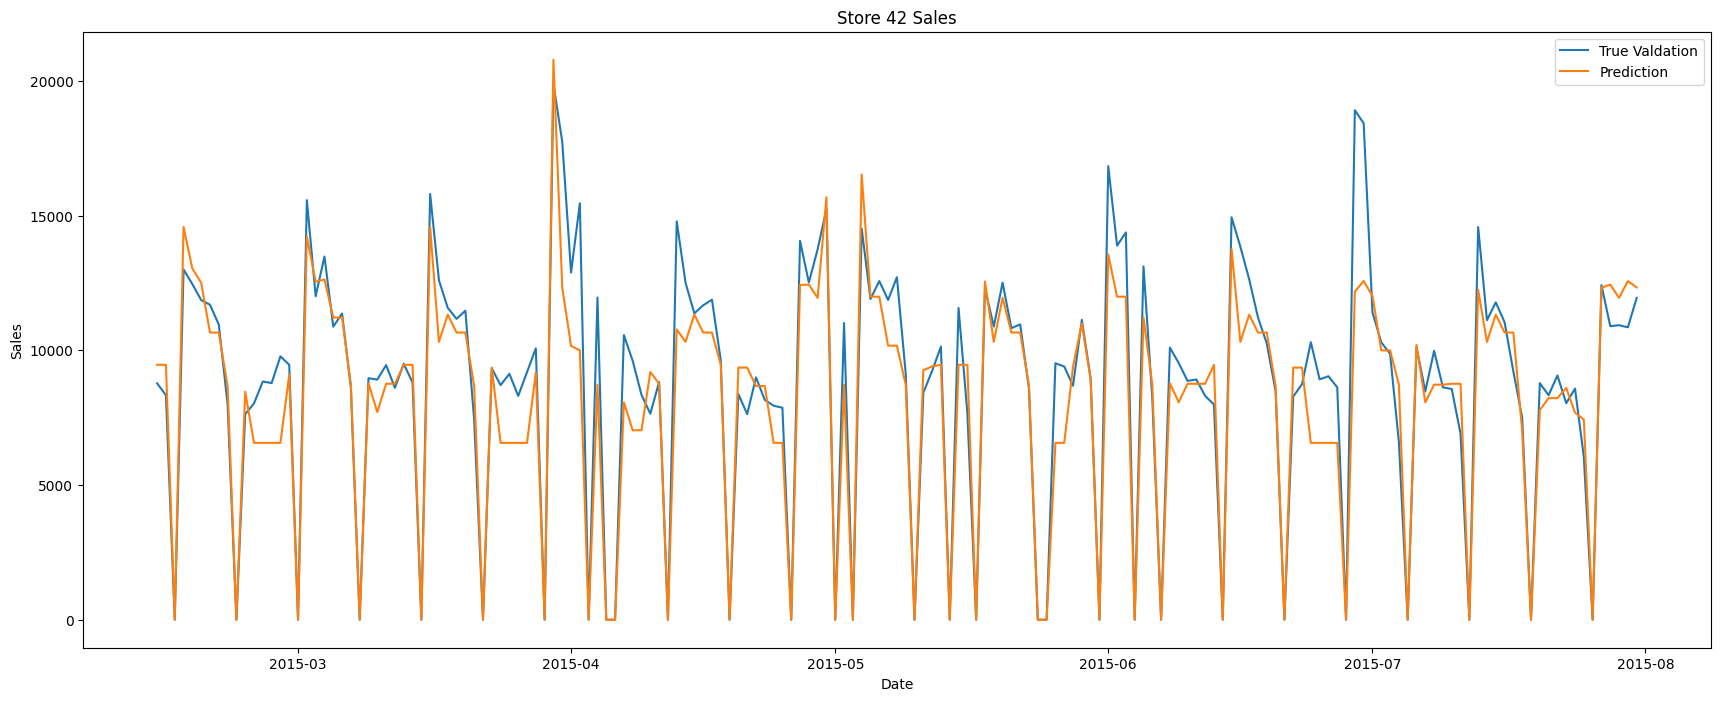

In [330]:
# plot the data for store 42 with the predictions
Plot_train_validation(store_42_validation, store_42_validation, 42, pred_col_name='Model_pred',Label1="True Valdation",Label2="Prediction" )

#### RandomForestRegressor

In [331]:
# Using Random Forest Regressor
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train_42, y_train_42)

y_pred_42 = rf.predict(X_val_42)

rmspe_score = rmspe(y_val_42 , y_pred_42 )
rmspe_score

0.14509041864782224

In [332]:
store_42_validation["Model_pred"] = y_pred_42

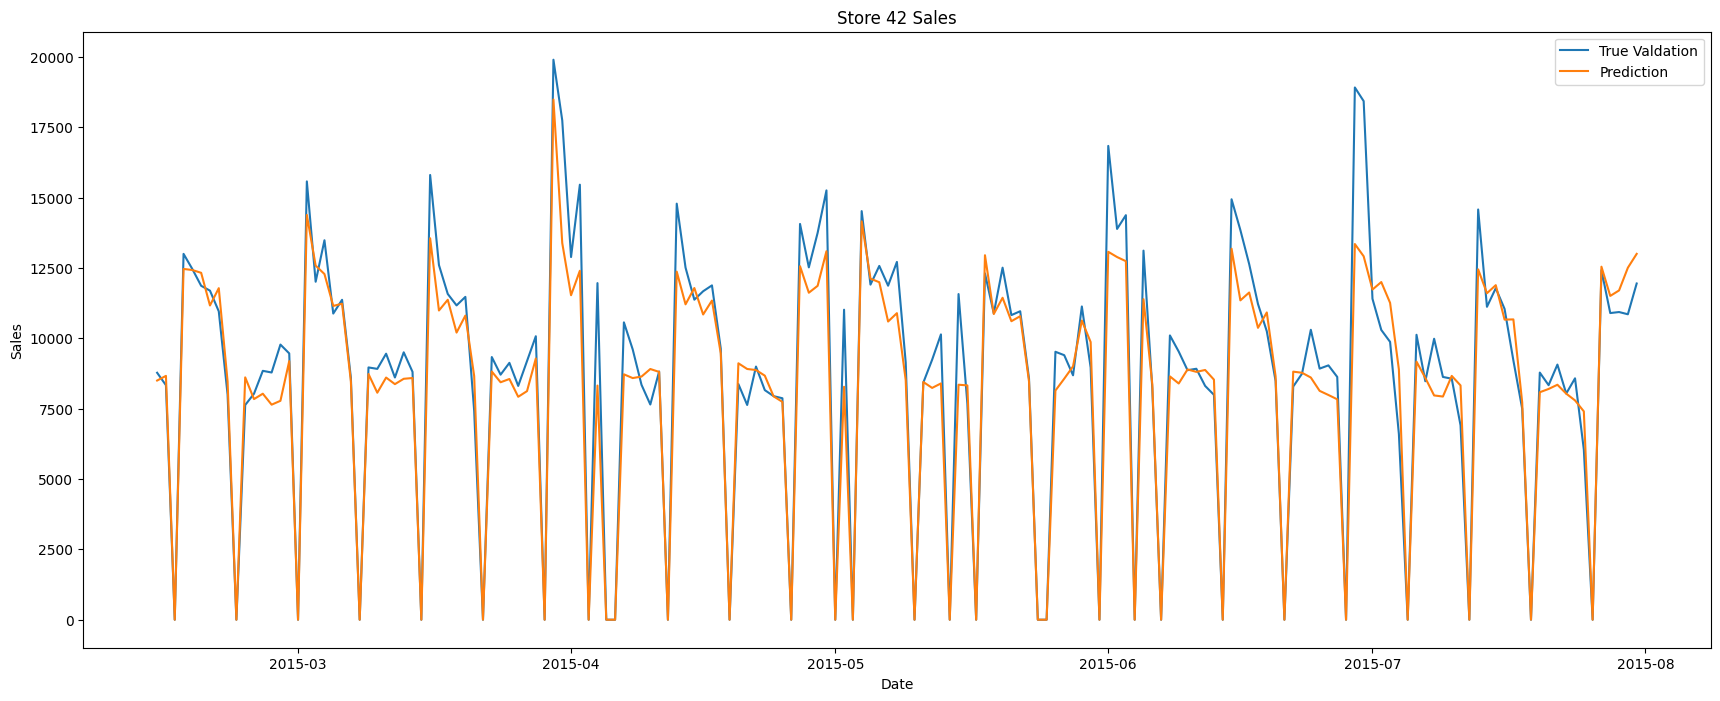

In [333]:
Plot_train_validation(store_42_validation, store_42_validation, 42, pred_col_name='Model_pred',Label1="True Valdation",Label2="Prediction" )


#### Some other stores :<br>

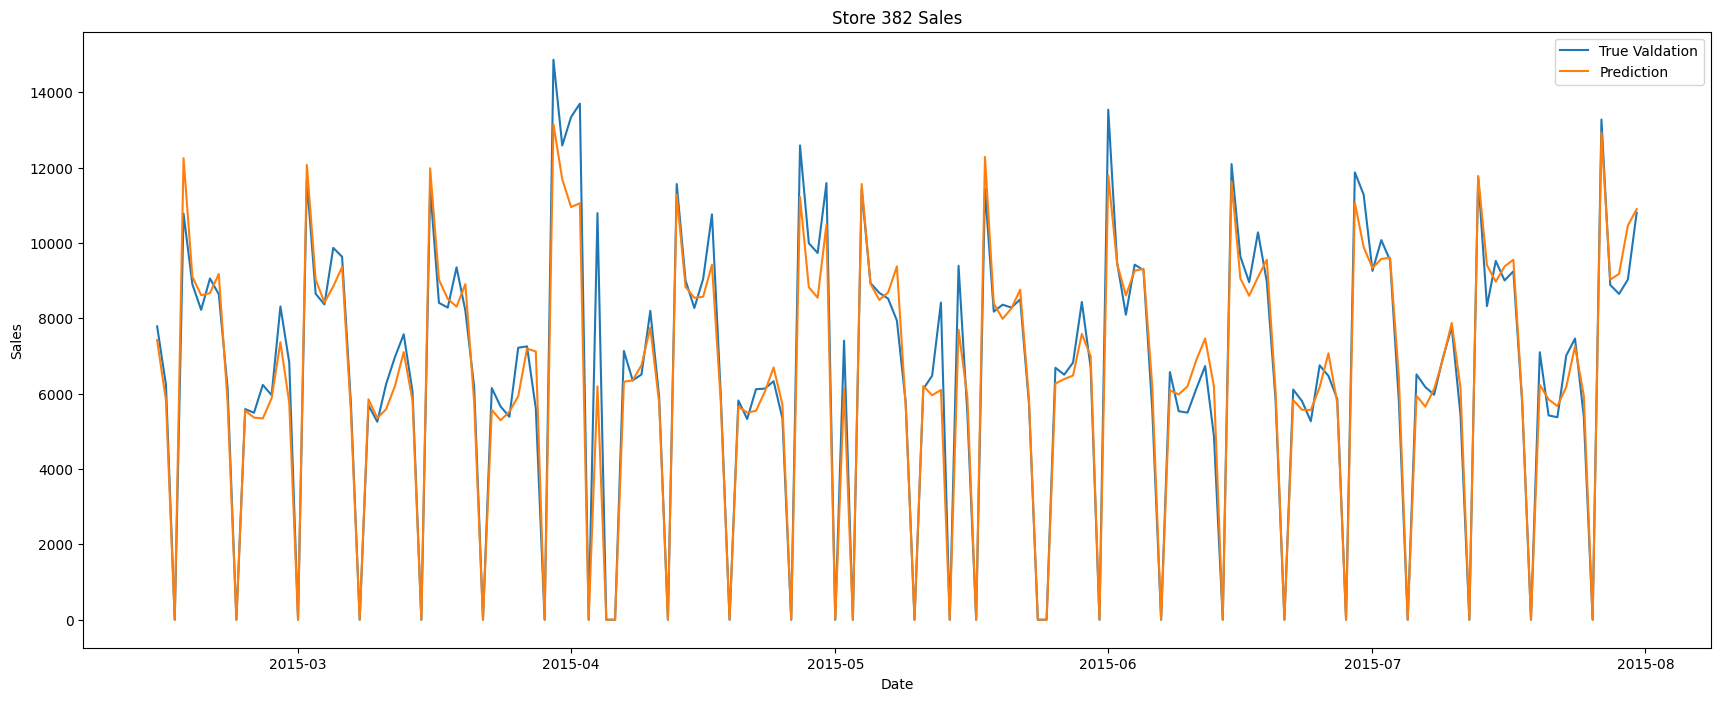

0.11565610638681283

In [334]:
random_forest_regressor(382, train_data, validation_data)


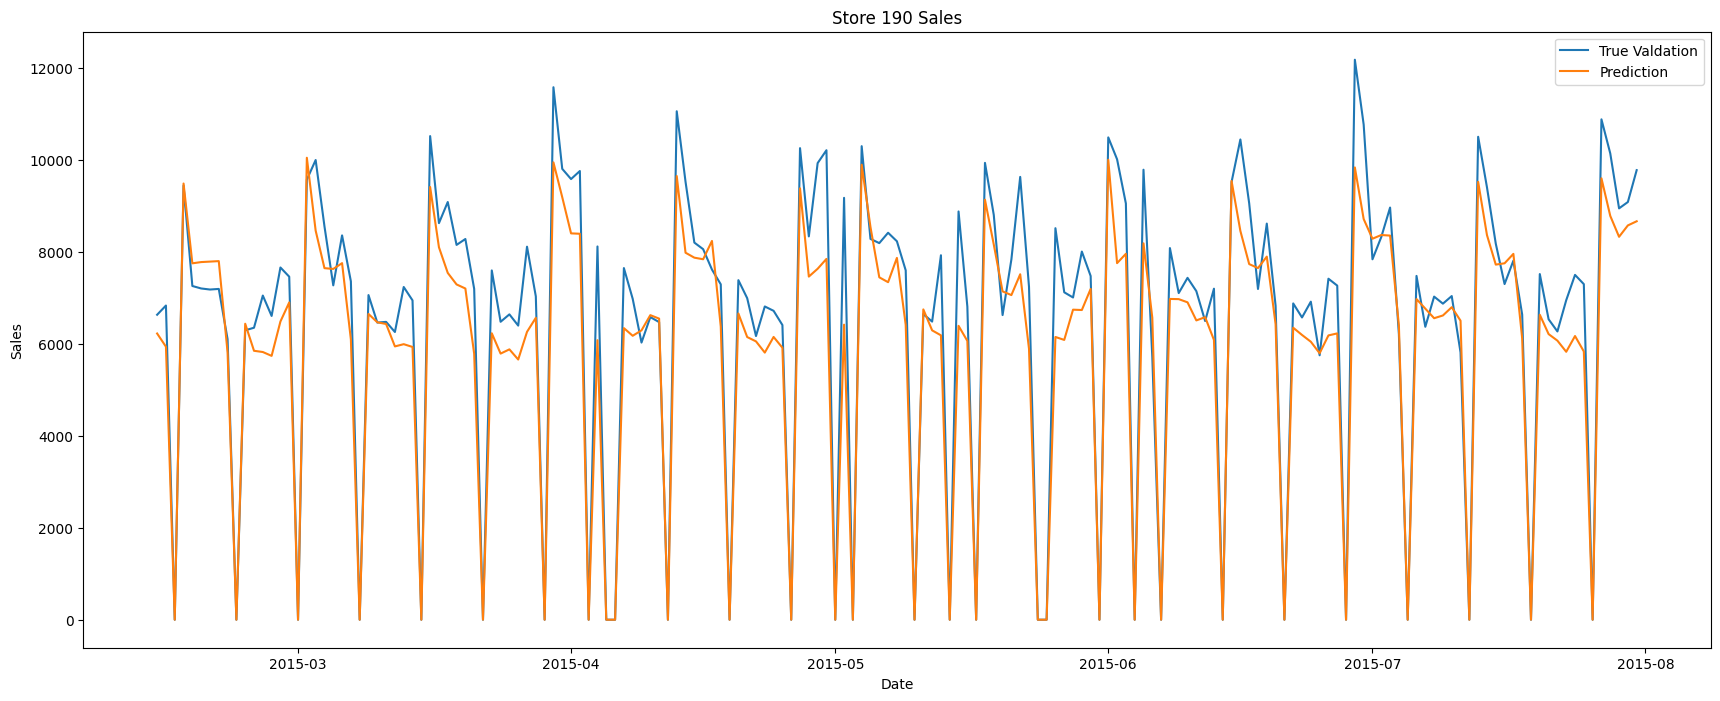

0.14489501430689117

In [320]:
random_forest_regressor(190, train_data, validation_data)


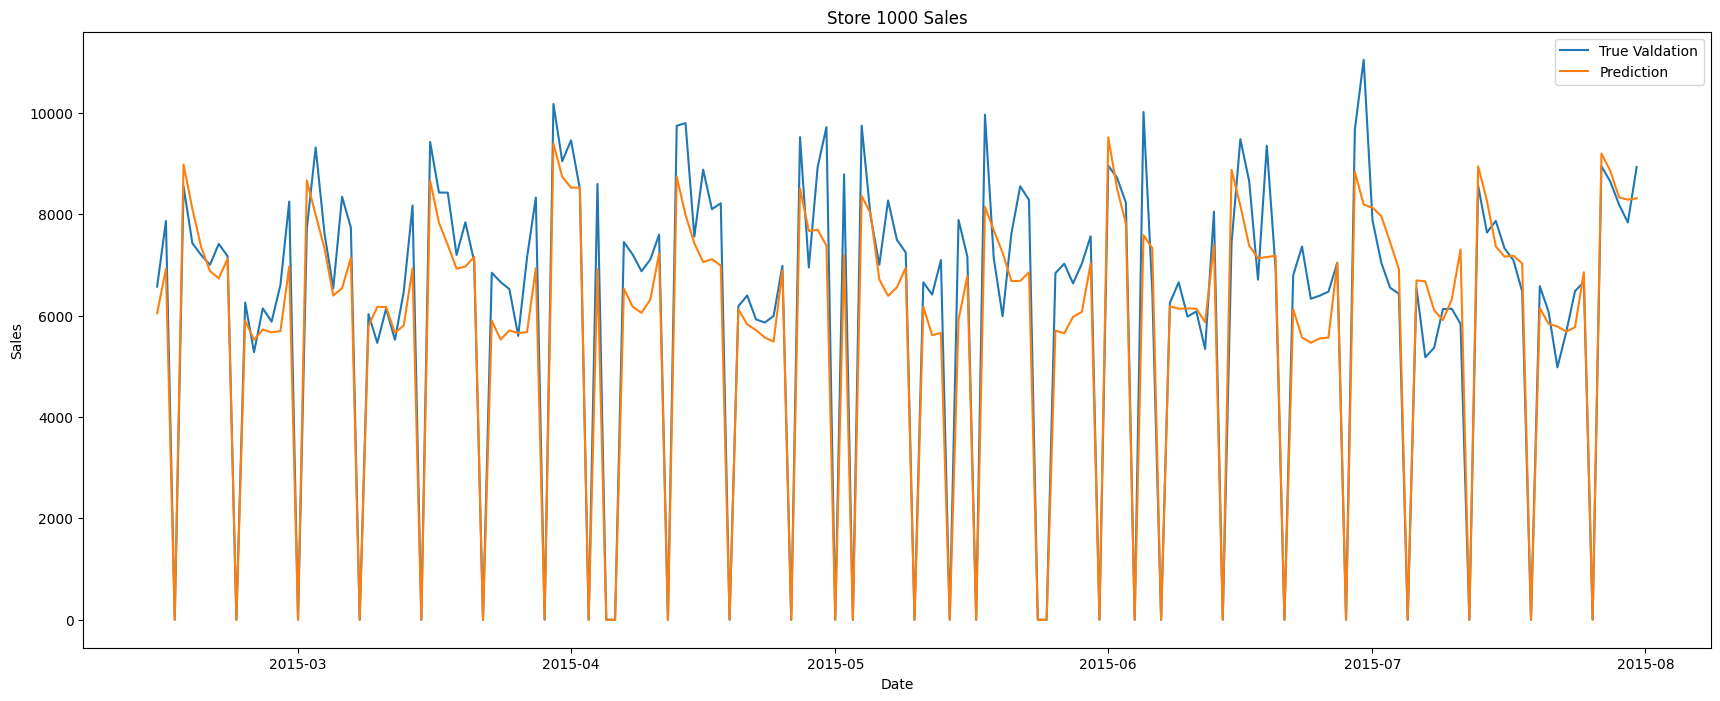

0.14222907130251417

In [321]:
random_forest_regressor(1000, train_data, validation_data)

## AutoML

Here I will use `TPOT` library to find the best model for the data withe the `Store` as a feature. <br>
TPOT is a Python Automated Machine Learning tool that optimizes machine learning pipelines using genetic programming. <br>
TPOT will automate the most tedious part of machine learning by intelligently exploring thousands of possible pipelines to find the best one for our data. <br>

In [335]:
X_train = train_data.drop(columns=['Sales' , 'Date'], axis=1)
y_train = train_data['Sales']

X_val = validation_data.drop(columns=['Sales' , 'Date'], axis=1)
y_val = validation_data['Sales']

X_train.shape, y_train.shape, X_val.shape, y_val.shape

((828774, 25), (828774,), (188432, 25), (188432,))

In [336]:

# Passing our scoring function
tpot = tpot.TPOTRegressor(generations=3, population_size=10, verbosity=2, random_state=42,scoring=['r2',rmspe])

tpot.fit(X_train, y_train)

print(tpot.score(X_val, y_val))

Optimization Progress:   0%|          | 0/40 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: -6279781.165705863

Generation 2 - Current best internal CV score: -6279781.165705863

Generation 3 - Current best internal CV score: -6068896.7156982515

Best pipeline: XGBRegressor(input_matrix, learning_rate=0.1, max_depth=2, min_child_weight=20, n_estimators=100, n_jobs=1, objective=reg:squarederror, subsample=0.35000000000000003, verbosity=0)
-5864807.373530234


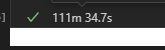

The model took a long time to run, so I will not run it again. <br>
I don't know why the scores are so low, and in negative values. 😅 <br>
but the model performance is not that bad I think. <br>

In [337]:
Tpot_pred = tpot.predict(X_val)

In [348]:
rmspe(y_val , Tpot_pred)

0.4094522598087145

In [341]:
validation_data['Model_pred'] = Tpot_pred

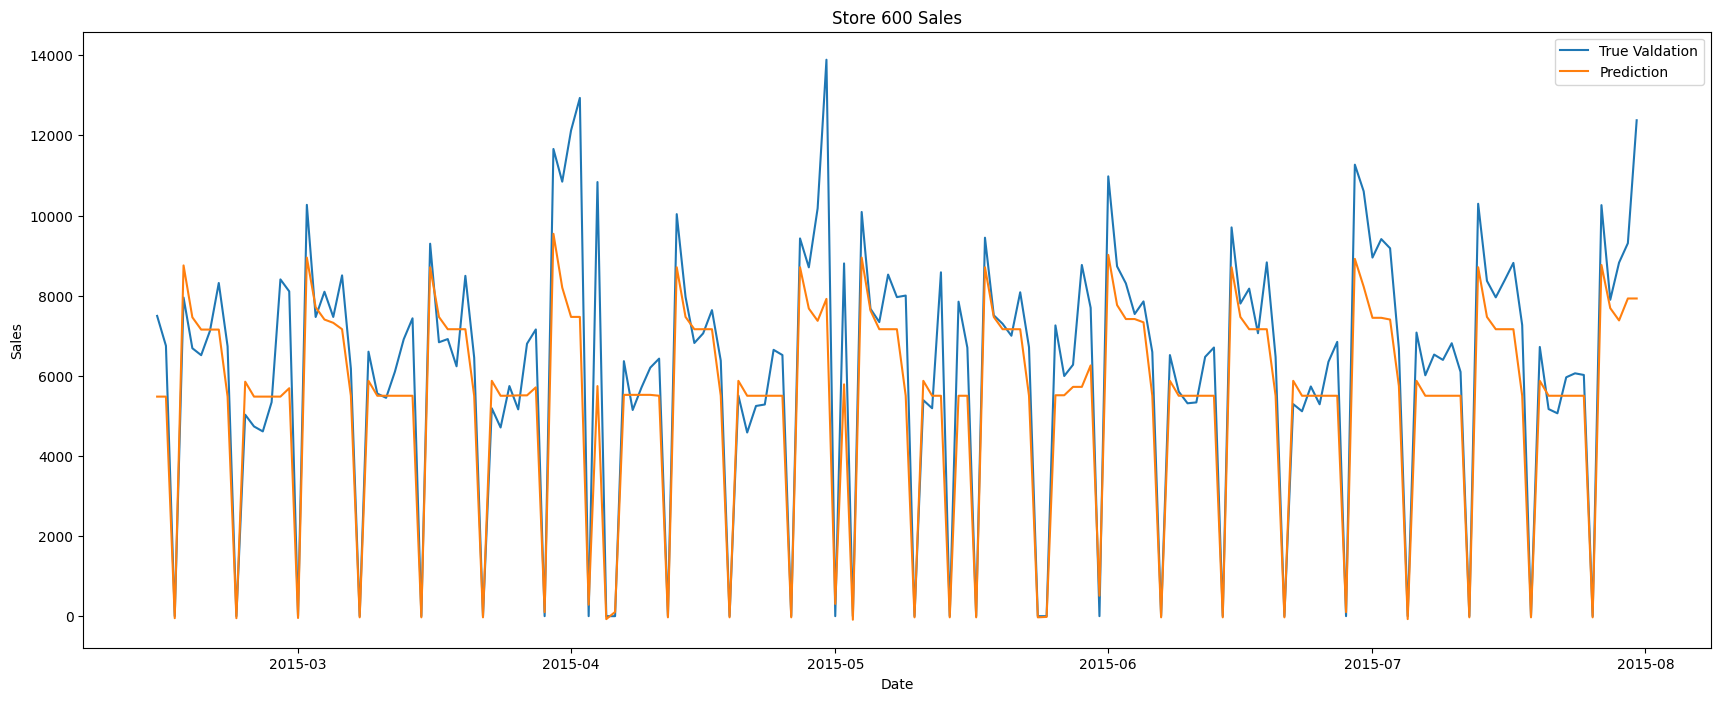

In [347]:
Plot_train_validation(validation_data, validation_data, 600, pred_col_name='Model_pred',Label1="True Valdation",Label2="Prediction" )

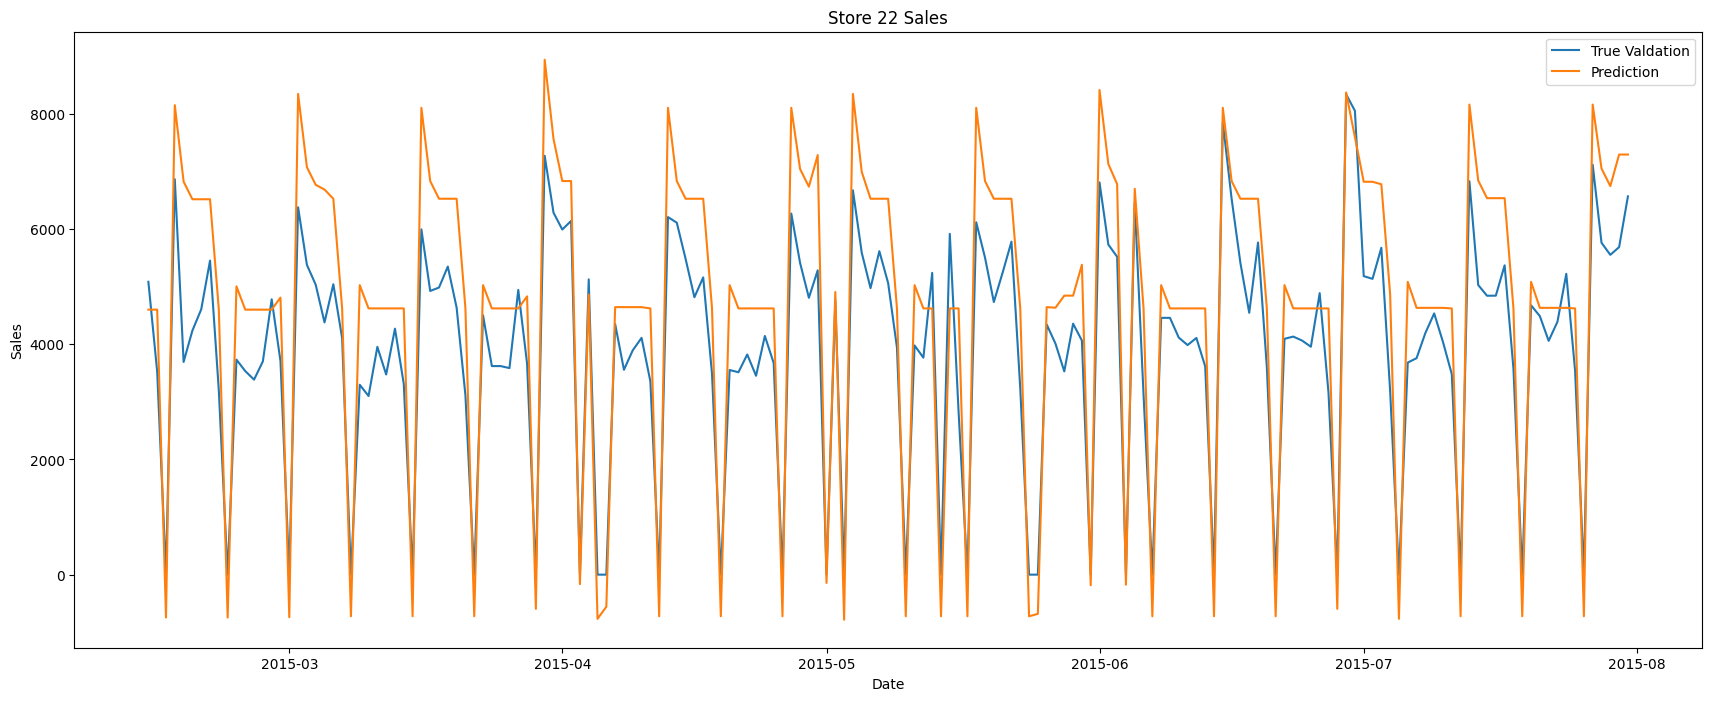

In [349]:
Plot_train_validation(validation_data, validation_data, 22, pred_col_name='Model_pred',Label1="True Valdation",Label2="Prediction" )

A good idea to use Tpot to find the best model for each store. <br>
and store the models in a dictionary to use them later. <br>
but this will take a long time to run. <br>

In [351]:

tpot_42 = tpot.TPOTRegressor(generations=3, population_size=10, verbosity=2, random_state=42,scoring='r2')

tpot_42.fit(X_train_42, y_train_42)

print(tpot_42.score(X_val_42, y_val_42))

Optimization Progress:   0%|          | 0/40 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: 0.9139823253713049

Generation 2 - Current best internal CV score: 0.9139823253713049

Generation 3 - Current best internal CV score: 0.9139823253713049

Best pipeline: RandomForestRegressor(input_matrix, bootstrap=True, max_features=0.7500000000000001, min_samples_leaf=11, min_samples_split=9, n_estimators=100)
0.9194075345154473


In [353]:
Tpot_pred_42 = tpot_42.predict(X_val_42)

In [355]:
rmspe(Tpot_pred_42, y_val_42)

0.1609895733157331

In [369]:
X_val_42['Model_pred'] = Tpot_pred_42

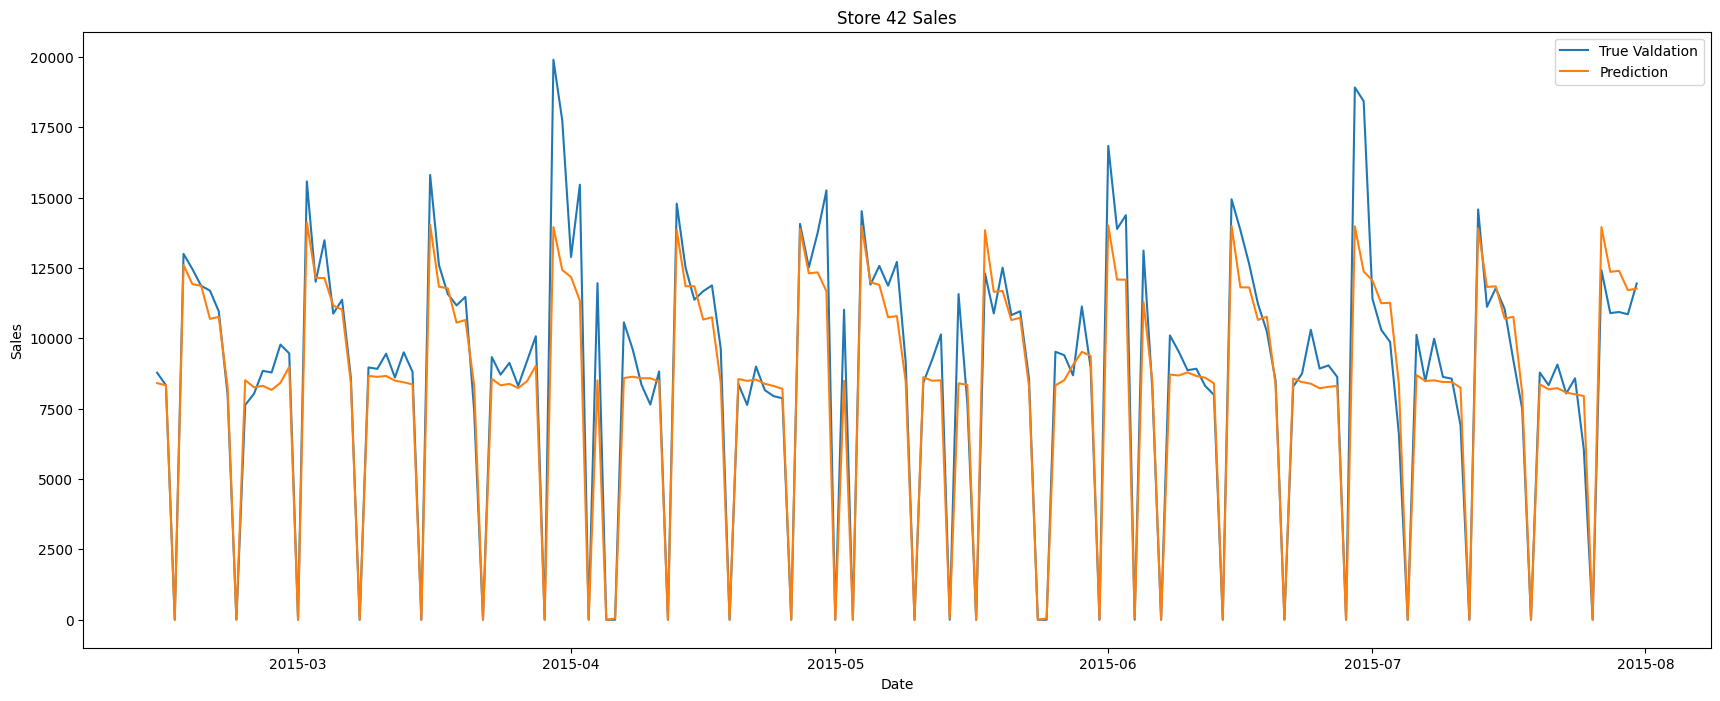

In [371]:
Plot_train_validation(validation_data, X_val_42, 42, pred_col_name='Model_pred',Label1="True Valdation",Label2="Prediction" )

### Final Model

The same model from `Tpot`, Sadly I accidentally rewrite the model variabel so i had to manually re train the best `Tpot` model.

In [ ]:
last_model = XGBRegressor(learning_rate=0.1, max_depth=2, min_child_weight=20, n_estimators=100, n_jobs=1)

In [ ]:
last_model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=2, max_leaves=None,
             min_child_weight=20, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=1,
             num_parallel_tree=None, random_state=None, ...)

In [387]:
VAL = last_model.predict(X_val)

In [389]:
rmspe(VAL,y_val)

0.4325518869714213

### Creating Kaggle Submission file

In [428]:
preds = last_model.predict(test.drop(columns=['Date','Id'], axis=1))

In [429]:
preds = pd.DataFrame(preds, columns=['Sales'])

In [430]:
preds

Sales
0       8873.331055
1       8255.336914
2       8015.324219
3       7162.365234
4       7791.799316
...             ...
41083   5211.466797
41084   6690.028809
41085   6386.119629
41086  10412.180664
41087   5308.946289

[41088 rows x 1 columns]

In [431]:
# convert predection to a DataFrame & add id (index)

preds['Id'] = test['Id']
preds = preds[['Id', 'Sales']]
preds.head()

Id        Sales
0   1  8873.331055
1   2  8255.336914
2   3  8015.324219
3   4  7162.365234
4   5  7791.799316

In [432]:
# Save the predictions to a CSV file
preds.to_csv('tpot_submission.csv', index=False)

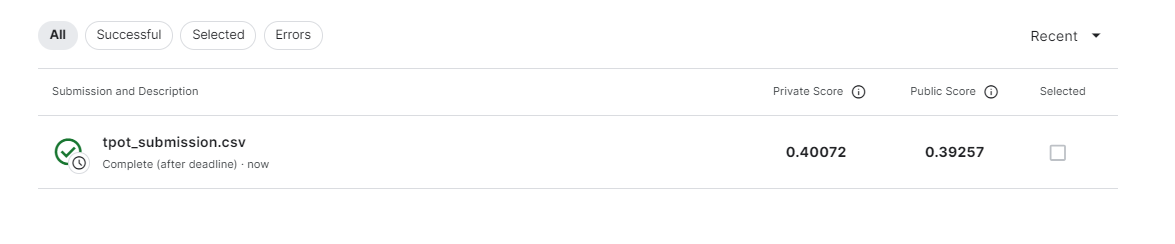